In [68]:
import json
import os
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import Counter
import numpy as np
from scipy import stats
import seaborn as sns 
from matplotlib.gridspec import GridSpec
from datetime import datetime
from scipy.stats import pearsonr
import statsmodels.api as sm
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import shap
from xgboost import XGBRegressor
from collections import defaultdict

In [2]:
def load_json(path):             # JSON 데이터 로드 함수
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

def save_json(path, data):
    with open(path, "w", encoding="utf-8") as f:  # 인코딩을 UTF-8로 지정
        json.dump(data, f, ensure_ascii=False, indent="\t")

필터링된 파일 불러오기

In [ ]:
data = load_json("filtered_json_data_2024_filtered.json")
raw_contents_info = pd.read_csv("filtered_member_list_2024_filtered.csv")

09/12 자료조사
==

메타 관련 정보 통계

In [4]:
list_user_id = list(data.keys())
meta_info = raw_meta_info[raw_meta_info["사용자ID"].isin(list_user_id)]

len(meta_info)

186

In [5]:
meta_info["성별"].value_counts(dropna=False)

성별
남자    156
여자     30
Name: count, dtype: int64

In [6]:
meta_info["군구분"].value_counts(dropna=False)

군구분
육군     167
공군      10
해군       6
해병대      2
국직       1
Name: count, dtype: int64

In [7]:
meta_info["구분"].value_counts(dropna=False)

구분
장병    106
간부     80
Name: count, dtype: int64

2023년 전 임관 및 입대: 96명
2023년 이후 임관 및 입대: 90명


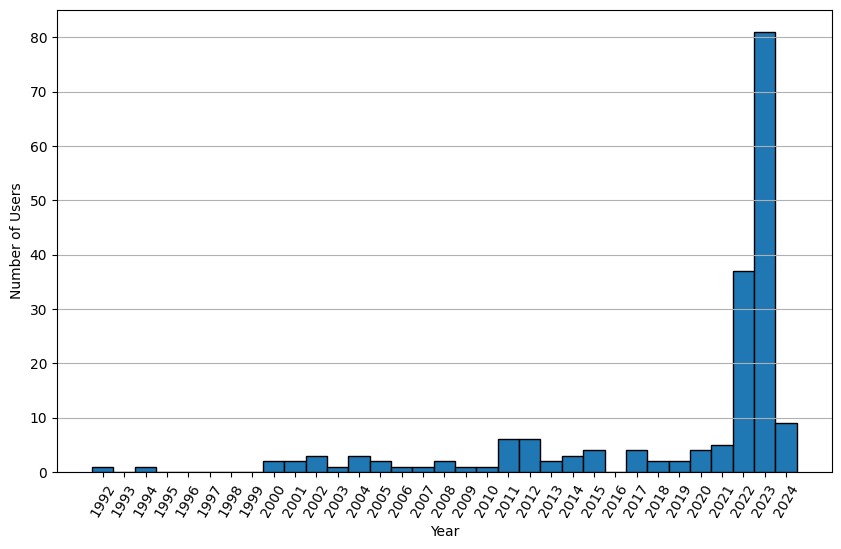

In [8]:
# 2023년 전 임관 및 입대자와 2023년 이후 임관 및 입대자 구분
before_2020 = meta_info[meta_info['임관년도'] < 2023].shape[0]
after_2023 = meta_info[meta_info['임관년도'] >= 2023].shape[0]

# 결과 출력
print(f"2023년 전 임관 및 입대: {before_2020}명")
print(f"2023년 이후 임관 및 입대: {after_2023}명")

# '임관년도' 열의 값 분포 그리기
plt.figure(figsize=(10, 6))
plt.hist(meta_info['임관년도'].dropna(), bins=range(int(meta_info['임관년도'].min()), int(meta_info['임관년도'].max()) + 2), edgecolor='black', align='left')
plt.xticks(range(int(meta_info['임관년도'].min()), int(meta_info['임관년도'].max()) + 1), rotation=60)
plt.grid(axis='y')

plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of Users', fontsize=10)

# 그래프 보여주기
plt.show()

2000년 전 출생: 88명
2000년 이후 출생: 98명


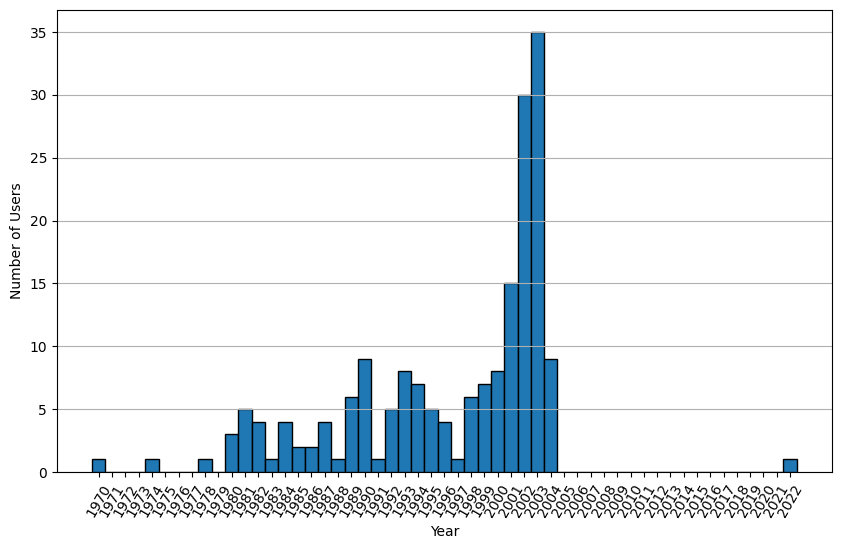

In [9]:
# 생년월일에서 연도 추출하여 2000년 전과 이후로 분류
meta_info['출생년도'] = meta_info['생년월일'].apply(lambda x: int(str(x)[:4]) if pd.notna(x) else None)

# 2000년 전 출생자와 2000년 이후 출생자 분류
before_1990 = meta_info[meta_info['출생년도'] < 2000].shape[0]
after_2000 = meta_info[meta_info['출생년도'] >= 2000].shape[0]

# 결과 출력
print(f"2000년 전 출생: {before_1990}명")
print(f"2000년 이후 출생: {after_2000}명")

# 출생년도 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(meta_info['출생년도'].dropna(), bins=range(int(meta_info['출생년도'].min()), int(meta_info['출생년도'].max()) + 2), edgecolor='black', align='left')
plt.xticks(range(int(meta_info['출생년도'].min()), int(meta_info['출생년도'].max()) + 1), rotation=60)
plt.grid(axis='y')

plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of Users', fontsize=10)

# 그래프 보여주기
plt.show()


메타 정보 기준으로의 데이터 분포 (사전, 사후 cesd-10-d 점수)

In [10]:
# 첫 번째(사전) 및 마지막(사후) CESD-10-D 점수 추출 함수
def extract_pre_post_scores_direct(data, user_ids):
    pre_scores = []
    post_scores = []
    
    for user_id in user_ids:
        if user_id in data:
            logs = data[user_id]
            pre_score = None
            post_score = None
            
            # 사전(CESD-10-D) 점수 찾기
            for idx, log in enumerate(logs):
                if log["CONTENTS_NAME"] == "cesd10d":
                    pre_score = log["SCORE"]  # 첫 번째 CESD-10-D 점수 (사전)
                    break  # 첫 번째 점수만 필요하므로 중단
                
            # 사후(CESD-10-D) 점수 찾기
            for idx in range(len(logs)-1, -1, -1):
                if logs[idx]["CONTENTS_NAME"] == "cesd10d":
                    post_score = logs[idx]["SCORE"]  # 마지막 CESD-10-D 점수 (사후)
                    break  # 마지막 점수만 필요하므로 중단
            
            if pre_score is not None and post_score is not None:
                pre_scores.append(pre_score)
                post_scores.append(post_score)
    
    return pre_scores, post_scores



# 앱 이용 기간 계산 함수
def calculate_usage_duration(data, user_ids):
    usage_durations = {}
    
    for user_id in user_ids:
        if user_id in data:
            # 사용자의 모든 로그에서 START_DATE 추출
            dates = [datetime.strptime(entry["START_DATE"], "%Y-%m-%d %H:%M:%S") for entry in data[user_id] if "START_DATE" in entry and entry["START_DATE"]]
            if dates:
                # 첫 번째 로그와 마지막 로그 간의 차이를 일 단위로 계산
                min_date = min(dates)
                max_date = max(dates)
                usage_duration = (max_date - min_date).days
                usage_durations[user_id] = usage_duration
    
    return usage_durations

# 분포 계산 함수
def calculate_pre_post_statistics_with_duration(group_data, data, label):
    user_ids = group_data["사용자ID"]
    pre_scores, post_scores = extract_pre_post_scores_direct(data, user_ids)
    usage_durations = calculate_usage_duration(data, user_ids)
    
    # 앱 이용 기간에 해당하는 사용자들만 필터링
    usage_duration_values = [usage_durations[user_id] for user_id in user_ids if user_id in usage_durations]
    
    if pre_scores and post_scores and usage_duration_values:  # 우울 점수와 이용 기간이 있는 경우만 계산
        print(f"[{label}]")
        print(f"data num: {len(pre_scores)}")
        
        # 사전 우울 점수
        print(f"pre score - average: {np.mean(pre_scores):.2f}, std: {np.std(pre_scores):.2f}, sem: {stats.sem(pre_scores):.2f}, min: {np.min(pre_scores):.2f}, max: {np.max(pre_scores):.2f}")
        
        # 사후 우울 점수
        print(f"post score - average: {np.mean(post_scores):.2f}, std: {np.std(post_scores):.2f}, sem: {stats.sem(post_scores):.2f}, min: {np.min(post_scores):.2f}, max: {np.max(post_scores):.2f}")
        
        # 앱 이용 기간 통계
        print(f"usage duration - average: {np.mean(usage_duration_values):.2f} days, std: {np.std(usage_duration_values):.2f} days, sem: {stats.sem(usage_duration_values):.2f} days, min: {np.min(usage_duration_values)} days, max: {np.max(usage_duration_values)} days")
        print("\n")
    else:
        print(f"[{label}] - 데이터 없음\n")
        



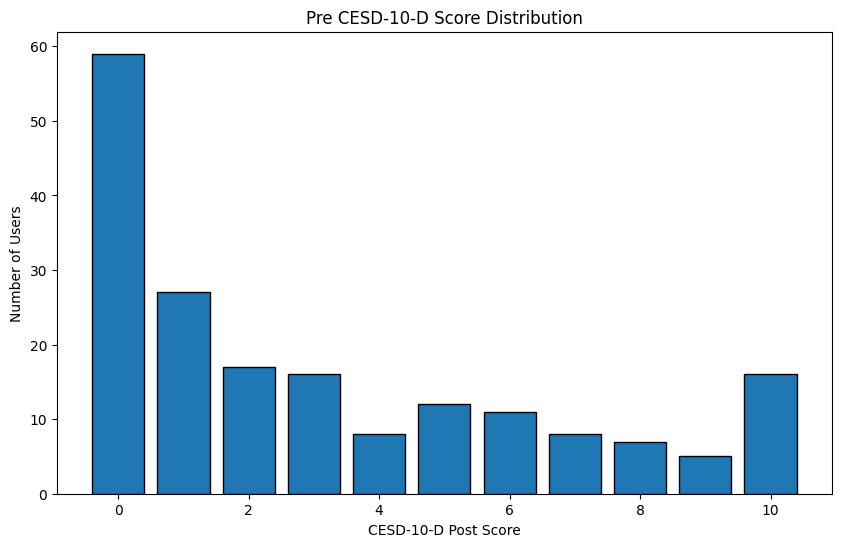

In [11]:
# 모든 사용자의 사전 CESD-10-D 점수 추출

pre_scores ,_ = extract_pre_post_scores_direct(data, meta_info['사용자ID'])

# 사전 CESD-10-D 점수 분포 그리기

score_counts = np.bincount(pre_scores, minlength=11)  # 0부터 10까지의 점수 카운트

plt.figure(figsize=(10, 6))
x = np.arange(0, 11)  # 점수 범위 0~10
plt.bar(x, score_counts, width=0.8, edgecolor='black') 
plt.xlabel('CESD-10-D Post Score')
plt.ylabel('Number of Users')
plt.title('Pre CESD-10-D Score Distribution')

# 그래프 보여주기
plt.show()

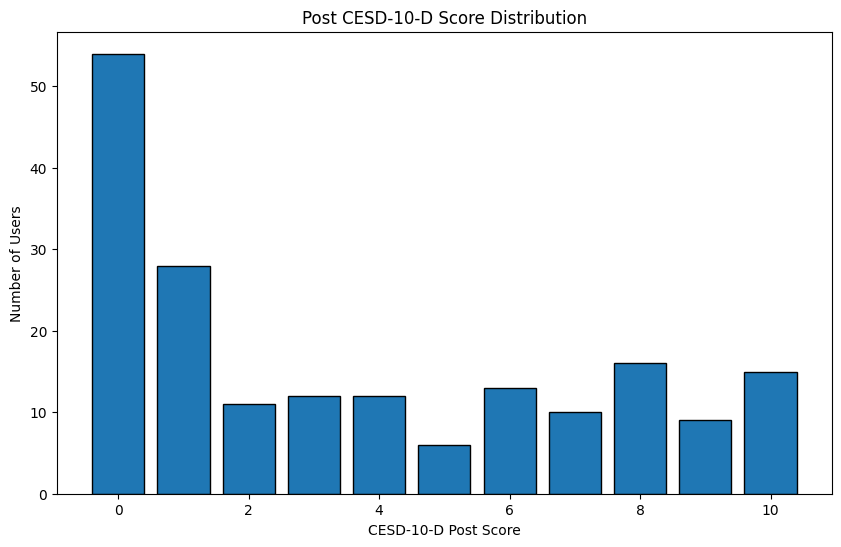

In [12]:
# 모든 사용자의 사후 CESD-10-D 점수 추출

_, post_scores = extract_pre_post_scores_direct(data, meta_info['사용자ID'])

# 사후 CESD-10-D 점수 분포 그리기
score_counts = np.bincount(post_scores, minlength=11)  # 0부터 10까지의 점수 카운트

plt.figure(figsize=(10, 6))
x = np.arange(0, 11)  # 점수 범위 0~10
plt.bar(x, score_counts, width=0.8, edgecolor='black') 
plt.xlabel('CESD-10-D Post Score')
plt.ylabel('Number of Users')
plt.title('Post CESD-10-D Score Distribution')

# 그래프 보여주기
plt.show()

In [13]:
# 성별에 따른 CESD-10-D 점수 분포 및 이용 기간 계산
for gender in meta_info["성별"].unique():
    group_data = meta_info[meta_info["성별"] == gender]
    calculate_pre_post_statistics_with_duration(group_data, data, f"성별: {gender}")

[성별: 남자]
data num: 156
pre score - average: 3.04, std: 3.33, sem: 0.27, min: 0.00, max: 10.00
post score - average: 3.46, std: 3.52, sem: 0.28, min: 0.00, max: 10.00
usage duration - average: 69.76 days, std: 71.64 days, sem: 5.75 days, min: 0 days, max: 353 days


[성별: 여자]
data num: 30
pre score - average: 3.67, std: 3.36, sem: 0.62, min: 0.00, max: 10.00
post score - average: 4.37, std: 3.48, sem: 0.65, min: 0.00, max: 10.00
usage duration - average: 105.93 days, std: 81.80 days, sem: 15.19 days, min: 0 days, max: 294 days




In [14]:
# 군소속에 따른 CESD-10-D 점수 분포 계산 함수
for military_branch in meta_info["군구분"].unique():
    group_data = meta_info[meta_info["군구분"] == military_branch]
    calculate_pre_post_statistics_with_duration(group_data, data, f"군소속: {military_branch}")

[군소속: 육군]
data num: 167
pre score - average: 3.11, std: 3.30, sem: 0.26, min: 0.00, max: 10.00
post score - average: 3.70, std: 3.57, sem: 0.28, min: 0.00, max: 10.00
usage duration - average: 74.46 days, std: 74.34 days, sem: 5.77 days, min: 0 days, max: 353 days


[군소속: 공군]
data num: 10
pre score - average: 4.60, std: 3.58, sem: 1.19, min: 0.00, max: 10.00
post score - average: 2.90, std: 2.02, sem: 0.67, min: 0.00, max: 6.00
usage duration - average: 79.90 days, std: 71.54 days, sem: 23.85 days, min: 13 days, max: 264 days


[군소속: 해군]
data num: 6
pre score - average: 1.83, std: 3.67, sem: 1.64, min: 0.00, max: 10.00
post score - average: 1.50, std: 3.35, sem: 1.50, min: 0.00, max: 9.00
usage duration - average: 72.83 days, std: 61.98 days, sem: 27.72 days, min: 1 days, max: 161 days


[군소속: 해병대]
data num: 2
pre score - average: 3.50, std: 1.50, sem: 1.50, min: 2.00, max: 5.00
post score - average: 6.50, std: 3.50, sem: 3.50, min: 3.00, max: 10.00
usage duration - average: 174.50 day

C:\Users\ppjw0\AppData\Local\Temp\ipykernel_22208\1952906218.py:63: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(f"pre score - average: {np.mean(pre_scores):.2f}, std: {np.std(pre_scores):.2f}, sem: {stats.sem(pre_scores):.2f}, min: {np.min(pre_scores):.2f}, max: {np.max(pre_scores):.2f}")
C:\Users\ppjw0\AppData\Local\Temp\ipykernel_22208\1952906218.py:66: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(f"post score - average: {np.mean(post_scores):.2f}, std: {np.std(post_scores):.2f}, sem: {stats.sem(post_scores):.2f}, min: {np.min(post_scores):.2f}, max: {np.max(post_scores):.2f}")
C:\Users\ppjw0\AppData\Local\Temp\ipykernel_22208\1952906218.py:69: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size 

In [15]:
# 계급에 따른 CESD-10-D 점수 분포 계산 함수
for rank in meta_info["구분"].unique():
    group_data = meta_info[meta_info["구분"] == rank]
    calculate_pre_post_statistics_with_duration(group_data, data, f"계급: {rank}")

[계급: 장병]
data num: 106
pre score - average: 3.34, std: 3.40, sem: 0.33, min: 0.00, max: 10.00
post score - average: 3.67, std: 3.49, sem: 0.34, min: 0.00, max: 10.00
usage duration - average: 62.40 days, std: 70.86 days, sem: 6.92 days, min: 0 days, max: 353 days


[계급: 간부]
data num: 80
pre score - average: 2.88, std: 3.23, sem: 0.36, min: 0.00, max: 10.00
post score - average: 3.52, std: 3.58, sem: 0.40, min: 0.00, max: 10.00
usage duration - average: 93.09 days, std: 75.75 days, sem: 8.52 days, min: 0 days, max: 294 days




In [16]:
# 2000년 이전 출생자
before_1990 = meta_info[meta_info["출생년도"] < 2000]
calculate_pre_post_statistics_with_duration(before_1990, data, "2000년 이전 출생")

# 2000년 이후 출생자
after_2000 = meta_info[meta_info["출생년도"] >= 2000]
calculate_pre_post_statistics_with_duration(after_2000, data, "2000년 이후 출생")

[2000년 이전 출생]
data num: 88
pre score - average: 3.07, std: 3.31, sem: 0.35, min: 0.00, max: 10.00
post score - average: 3.50, std: 3.58, sem: 0.38, min: 0.00, max: 10.00
usage duration - average: 91.74 days, std: 78.94 days, sem: 8.46 days, min: 0 days, max: 353 days


[2000년 이후 출생]
data num: 98
pre score - average: 3.20, std: 3.37, sem: 0.34, min: 0.00, max: 10.00
post score - average: 3.70, std: 3.47, sem: 0.35, min: 0.00, max: 10.00
usage duration - average: 61.10 days, std: 67.19 days, sem: 6.82 days, min: 0 days, max: 284 days




In [17]:
# 2023년 이전 임관 및 입대자
before_2020 = meta_info[meta_info["임관년도"] < 2023]
calculate_pre_post_statistics_with_duration(before_2020, data, "2023년 전 임관 및 입대")

# 2023년 이후 임관 및 입대자
after_2023 = meta_info[meta_info["임관년도"] >= 2023]
calculate_pre_post_statistics_with_duration(after_2023, data, "2023년 이후 임관 및 입대")


[2023년 전 임관 및 입대]
data num: 96
pre score - average: 2.74, std: 3.23, sem: 0.33, min: 0.00, max: 10.00
post score - average: 3.22, std: 3.43, sem: 0.35, min: 0.00, max: 10.00
usage duration - average: 76.22 days, std: 71.36 days, sem: 7.32 days, min: 0 days, max: 294 days


[2023년 이후 임관 및 입대]
data num: 90
pre score - average: 3.57, std: 3.40, sem: 0.36, min: 0.00, max: 10.00
post score - average: 4.02, std: 3.58, sem: 0.38, min: 0.00, max: 10.00
usage duration - average: 74.93 days, std: 77.84 days, sem: 8.25 days, min: 0 days, max: 353 days




09/19 자료 조사
==

* 입대년도, 출생년도 3가지 기준으로 다시 분류


In [18]:
# 1994년 이전 출생자
before_1994 = meta_info[meta_info["출생년도"] < 1994]
calculate_pre_post_statistics_with_duration(before_1994, data, "1994년 이전 출생")

# 1994년부터 2001년 사이 출생자
between_1994_2002 = meta_info[(meta_info["출생년도"] >= 1994) & (meta_info["출생년도"] <= 2001)]
calculate_pre_post_statistics_with_duration(between_1994_2002, data, "1994년 ~ 2001년 출생")

# 2001년 이후 출생자
after_2002 = meta_info[meta_info["출생년도"] > 2001]
calculate_pre_post_statistics_with_duration(after_2002, data, "2001년 이후 출생")


[1994년 이전 출생]
data num: 58
pre score - average: 2.83, std: 3.27, sem: 0.43, min: 0.00, max: 10.00
post score - average: 3.53, std: 3.60, sem: 0.48, min: 0.00, max: 10.00
usage duration - average: 97.76 days, std: 79.56 days, sem: 10.54 days, min: 0 days, max: 294 days


[1994년 ~ 2001년 출생]
data num: 53
pre score - average: 3.36, std: 3.25, sem: 0.45, min: 0.00, max: 10.00
post score - average: 3.51, std: 3.39, sem: 0.47, min: 0.00, max: 10.00
usage duration - average: 64.53 days, std: 70.76 days, sem: 9.81 days, min: 0 days, max: 353 days


[2001년 이후 출생]
data num: 75
pre score - average: 3.23, std: 3.44, sem: 0.40, min: 0.00, max: 10.00
post score - average: 3.73, std: 3.56, sem: 0.41, min: 0.00, max: 10.00
usage duration - average: 66.28 days, std: 69.31 days, sem: 8.06 days, min: 1 days, max: 284 days




In [19]:
# 2020년 이전 임관 및 입대자
before_2020 = meta_info[meta_info["임관년도"] < 2020]
calculate_pre_post_statistics_with_duration(before_2020, data, "2020년 이전 임관 및 입대")

# 2020년부터 2022년 사이 임관 및 입대자
between_2020_2023 = meta_info[(meta_info["임관년도"] >= 2020) & (meta_info["임관년도"] <= 2022)]
calculate_pre_post_statistics_with_duration(between_2020_2023, data, "2020년~2022년 임관 및 입대")

# 2022년 이후 임관 및 입대자
after_2023 = meta_info[meta_info["임관년도"] > 2022]
calculate_pre_post_statistics_with_duration(after_2023, data, "2022년 이후 임관 및 입대")


[2020년 이전 임관 및 입대]
data num: 50
pre score - average: 2.68, std: 3.30, sem: 0.47, min: 0.00, max: 10.00
post score - average: 3.66, std: 3.69, sem: 0.53, min: 0.00, max: 10.00
usage duration - average: 97.66 days, std: 78.90 days, sem: 11.27 days, min: 1 days, max: 294 days


[2020년~2022년 임관 및 입대]
data num: 46
pre score - average: 2.80, std: 3.16, sem: 0.47, min: 0.00, max: 10.00
post score - average: 2.74, std: 3.05, sem: 0.45, min: 0.00, max: 10.00
usage duration - average: 52.91 days, std: 53.10 days, sem: 7.92 days, min: 0 days, max: 264 days


[2022년 이후 임관 및 입대]
data num: 90
pre score - average: 3.57, std: 3.40, sem: 0.36, min: 0.00, max: 10.00
post score - average: 4.02, std: 3.58, sem: 0.38, min: 0.00, max: 10.00
usage duration - average: 74.93 days, std: 77.84 days, sem: 8.25 days, min: 0 days, max: 353 days




* 앱 사용 기간에 따른 우울 척도 점수 변화 추출하기

In [20]:
def calculate_pre_post_statistics_by_usage_duration(data, meta_info, duration_ranges):
    # 앱 이용 기간 계산
    usage_durations = calculate_usage_duration(data, meta_info["사용자ID"])
    
    # 각 범위에 대해 통계 계산
    for label, (min_days, max_days) in duration_ranges.items():
        # 지정된 범위에 맞는 사용자 필터링
        filtered_users = [user_id for user_id, duration in usage_durations.items() if min_days <= duration < max_days]
        group_data = meta_info[meta_info["사용자ID"].isin(filtered_users)]
        
        # 통계 계산
        calculate_pre_post_statistics_with_duration(group_data, data, label)


In [21]:
# 앱 사용 기간에 따른 분류 범위 설정
duration_ranges = {
    "25일 미만": (0, 25),
    "25일 이상 75일 미만": (25, 75),
    "75일 이상": (75, float('inf'))
}

# 앱 사용 기간에 따른 우울 척도 점수 변화 분석
calculate_pre_post_statistics_by_usage_duration(data, meta_info, duration_ranges)


[25일 미만]
data num: 59
pre score - average: 2.56, std: 3.21, sem: 0.42, min: 0.00, max: 10.00
post score - average: 3.02, std: 3.41, sem: 0.45, min: 0.00, max: 10.00
usage duration - average: 13.00 days, std: 8.20 days, sem: 1.08 days, min: 0 days, max: 24 days


[25일 이상 75일 미만]
data num: 61
pre score - average: 3.51, std: 3.56, sem: 0.46, min: 0.00, max: 10.00
post score - average: 3.84, std: 3.67, sem: 0.47, min: 0.00, max: 10.00
usage duration - average: 44.64 days, std: 13.94 days, sem: 1.80 days, min: 25 days, max: 74 days


[75일 이상]
data num: 66
pre score - average: 3.32, std: 3.17, sem: 0.39, min: 0.00, max: 10.00
post score - average: 3.92, std: 3.43, sem: 0.42, min: 0.00, max: 10.00
usage duration - average: 160.17 days, std: 62.37 days, sem: 7.74 days, min: 77 days, max: 353 days




* 전체 사용자의 우울 척도 점수 변화

In [22]:
# 전체 사용자의 우울 척도 점수 변화 계산
calculate_pre_post_statistics_with_duration(meta_info, data, "전체 사용자")


[전체 사용자]
data num: 186
pre score - average: 3.14, std: 3.34, sem: 0.25, min: 0.00, max: 10.00
post score - average: 3.61, std: 3.53, sem: 0.26, min: 0.00, max: 10.00
usage duration - average: 75.60 days, std: 74.57 days, sem: 5.48 days, min: 0 days, max: 353 days




In [23]:
#우울증 검사 점수 변화 계산
def calculate_score_changes(data, user_ids):
    increase_scores = []
    decrease_scores = []
    no_change_scores = []

    for user_id in user_ids:
        if user_id in data:
            logs = data[user_id]
            pre_score = None
            post_score = None

            # 사전 점수 (first CESD-10-D score)
            for idx, log in enumerate(logs):
                if log["CONTENTS_NAME"] == "cesd10d":
                    pre_score = log["SCORE"]
                    break

            # 사후 점수 (last CESD-10-D score)
            for idx in range(len(logs) - 1, -1, -1):
                if logs[idx]["CONTENTS_NAME"] == "cesd10d":
                    post_score = logs[idx]["SCORE"]
                    break

            if pre_score is not None and post_score is not None:
                if post_score > pre_score:
                    increase_scores.append(post_score - pre_score)
                elif post_score < pre_score:
                    decrease_scores.append(pre_score - post_score)
                else:
                    no_change_scores.append(0)  # 변화없음

    return increase_scores, decrease_scores, no_change_scores

#출력
def print_score_change_statistics(label, scores):
    if scores:
        avg = np.mean(scores)
        std = np.std(scores)
        sem = stats.sem(scores)
        print(f"[{label}]")
        print(f"data num: {len(scores)}")
        print(f"average change: {avg:.2f}, std: {std:.2f}, sem: {sem:.2f}")
    else:
        print(f"[{label}] - 데이터 없음")

In [24]:
#전체 사용자의 우울 척도 증감 분포

user_ids = meta_info["사용자ID"]
increase_scores, decrease_scores, no_change_scores = calculate_score_changes(data, user_ids)

print("[전체 사용자]")

print_score_change_statistics("증가", increase_scores)
print_score_change_statistics("감소", decrease_scores)
print_score_change_statistics("변화없음", no_change_scores)

[전체 사용자]
[증가]
data num: 72
average change: 3.15, std: 2.20, sem: 0.26
[감소]
data num: 55
average change: 2.55, std: 1.83, sem: 0.25
[변화없음]
data num: 59
average change: 0.00, std: 0.00, sem: 0.00


* 우울 척도 점수 차이 검정을 위한 함수 정의 및 데이터 추출

In [25]:
def calculate_score_difference_statistics(pre_scores, post_scores):
    # 점수 차이 계산
    score_differences = np.array(post_scores) - np.array(pre_scores)
    
    # 평균, 표준 편차
    mean_diff = np.mean(score_differences)
    std_diff = np.std(score_differences, ddof=1)  # 표본 표준 편차

    # 95% 신뢰 구간
    conf_interval = stats.t.interval(0.95, len(score_differences)-1, loc=mean_diff, scale=stats.sem(score_differences))
    
    # 대응 표본 t-검정
    t_stat, p_value = stats.ttest_rel(pre_scores, post_scores)
    
    # 자유도 (df)
    df = len(score_differences) - 1
    
    print(f"우울 척도 점수 차이 검정")
    print(f"평균: {mean_diff:.2f}")
    print(f"표준 편차: {std_diff:.2f}")
    print(f"95% 신뢰 구간: 하한 = {conf_interval[0]:.2f}, 상한 = {conf_interval[1]:.2f}")
    print(f"t-값: {t_stat:.2f}")
    print(f"p-value: {p_value:.4f}")
    print(f"자유도 (df): {df}")
    
    return {
        "mean_diff": mean_diff,
        "std_diff": std_diff,
        "conf_interval": conf_interval,
        "t_stat": t_stat,
        "p_value": p_value,
        "df": df
    }



In [26]:
# 총 사용자에 따른 점수 차이 검정
user_ids = meta_info["사용자ID"]
print("[전체 사용자]")
pre_scores, post_scores = extract_pre_post_scores_direct(data, user_ids)
score_diff_stats = calculate_score_difference_statistics(pre_scores, post_scores)

[전체 사용자]
우울 척도 점수 차이 검정
평균: 0.47
표준 편차: 2.91
95% 신뢰 구간: 하한 = 0.05, 상한 = 0.89
t-값: -2.20
p-value: 0.0294
자유도 (df): 185


In [27]:
# 성별에 따른 점수 차이 검정
for gender in meta_info["성별"].unique():
    group_data = meta_info[meta_info["성별"] == gender]
    user_ids = group_data["사용자ID"]
    pre_scores, post_scores = extract_pre_post_scores_direct(data, user_ids)
    print(f"[{f"성별: {gender}"}]")
    score_diff_stats = calculate_score_difference_statistics(pre_scores, post_scores)

[성별: 남자]
우울 척도 점수 차이 검정
평균: 0.42
표준 편차: 2.88
95% 신뢰 구간: 하한 = -0.03, 상한 = 0.88
t-값: -1.84
p-value: 0.0681
자유도 (df): 155
[성별: 여자]
우울 척도 점수 차이 검정
평균: 0.70
표준 편차: 3.10
95% 신뢰 구간: 하한 = -0.46, 상한 = 1.86
t-값: -1.24
p-value: 0.2258
자유도 (df): 29


In [28]:
# 군소속에 따른 우울 척도 점수 차이 검정
for 군구분 in meta_info["군구분"].unique():
    group_data = meta_info[meta_info["군구분"] == 군구분]
    user_ids = group_data["사용자ID"]
    pre_scores, post_scores = extract_pre_post_scores_direct(data, user_ids)
    
    print(f"[군구분: {군구분}]")
    score_diff_stats = calculate_score_difference_statistics(pre_scores, post_scores)
    print("\n")


[군구분: 육군]
우울 척도 점수 차이 검정
평균: 0.59
표준 편차: 2.90
95% 신뢰 구간: 하한 = 0.14, 상한 = 1.03
t-값: -2.61
p-value: 0.0098
자유도 (df): 166


[군구분: 공군]
우울 척도 점수 차이 검정
평균: -1.70
표준 편차: 3.09
95% 신뢰 구간: 하한 = -3.91, 상한 = 0.51
t-값: 1.74
p-value: 0.1162
자유도 (df): 9


[군구분: 해군]
우울 척도 점수 차이 검정
평균: -0.33
표준 편차: 0.52
95% 신뢰 구간: 하한 = -0.88, 상한 = 0.21
t-값: 1.58
p-value: 0.1747
자유도 (df): 5


[군구분: 해병대]
우울 척도 점수 차이 검정
평균: 3.00
표준 편차: 2.83
95% 신뢰 구간: 하한 = -22.41, 상한 = 28.41
t-값: -1.50
p-value: 0.3743
자유도 (df): 1


[군구분: 국직]
우울 척도 점수 차이 검정
평균: 2.00
표준 편차: nan
95% 신뢰 구간: 하한 = nan, 상한 = nan
t-값: nan
p-value: nan
자유도 (df): 0




c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\ppjw0\AppData\Local\Temp\ipykernel_22208\2977028716.py:10: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  conf_interval = stats.t.interval(0.95, len(score_differences)-1, loc=mean_diff, scale=stats.sem(score_differences))
c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\ppjw0\AppData\Local\Programs

In [29]:
# 계급에 따른 우울 척도 점수 차이 검정
for 구분 in meta_info["구분"].unique():
    group_data = meta_info[meta_info["구분"] == 구분]
    user_ids = group_data["사용자ID"]
    pre_scores, post_scores = extract_pre_post_scores_direct(data, user_ids)
    
    print(f"[계급: {구분}]")
    score_diff_stats = calculate_score_difference_statistics(pre_scores, post_scores)
    print("\n")


[계급: 장병]
우울 척도 점수 차이 검정
평균: 0.33
표준 편차: 2.65
95% 신뢰 구간: 하한 = -0.18, 상한 = 0.84
t-값: -1.28
p-value: 0.2024
자유도 (df): 105


[계급: 간부]
우울 척도 점수 차이 검정
평균: 0.65
표준 편차: 3.22
95% 신뢰 구간: 하한 = -0.07, 상한 = 1.37
t-값: -1.80
p-value: 0.0750
자유도 (df): 79




In [30]:
# 2020년 이전 임관 및 입대자
before_2020 = meta_info[meta_info["임관년도"] < 2020]
user_ids_before_2020 = before_2020["사용자ID"]
pre_scores_before_2020, post_scores_before_2020 = extract_pre_post_scores_direct(data, user_ids_before_2020)
print("[임관년도: 2020년 전]")
calculate_score_difference_statistics(pre_scores_before_2020, post_scores_before_2020)
print("\n")

# 2020년부터 2022년 사이 임관 및 입대자
between_2020_2023 = meta_info[(meta_info["임관년도"] >= 2020) & (meta_info["임관년도"] < 2022)]
user_ids_between_2020_2022 = between_2020_2023["사용자ID"]
pre_scores_between_2020_2022, post_scores_between_2020_2022 = extract_pre_post_scores_direct(data, user_ids_between_2020_2022)
print("[임관년도: 2020년 이후 ~ 2022년 전]")
calculate_score_difference_statistics(pre_scores_between_2020_2022, post_scores_between_2020_2022)
print("\n")

# 2022년 이후 임관 및 입대자
after_2023 = meta_info[meta_info["임관년도"] >= 2022]
user_ids_after_2022 = after_2023["사용자ID"]
pre_scores_after_2022, post_scores_after_2022 = extract_pre_post_scores_direct(data, user_ids_after_2022)
print("[임관년도: 2022년 이후]")
calculate_score_difference_statistics(pre_scores_after_2022, post_scores_after_2022)
print("\n")


[임관년도: 2020년 전]
우울 척도 점수 차이 검정
평균: 0.98
표준 편차: 2.59
95% 신뢰 구간: 하한 = 0.24, 상한 = 1.72
t-값: -2.67
p-value: 0.0101
자유도 (df): 49


[임관년도: 2020년 이후 ~ 2022년 전]
우울 척도 점수 차이 검정
평균: -0.11
표준 편차: 5.01
95% 신뢰 구간: 하한 = -3.96, 상한 = 3.74
t-값: 0.07
p-value: 0.9486
자유도 (df): 8


[임관년도: 2022년 이후]
우울 척도 점수 차이 검정
평균: 0.31
표준 편차: 2.84
95% 신뢰 구간: 하한 = -0.19, 상한 = 0.81
t-값: -1.22
p-value: 0.2246
자유도 (df): 126




In [31]:
# 출생년도에 따른 우울 척도 점수 차이 검정

# 1994년 이전 출생자
before_1994 = meta_info[meta_info["출생년도"] < 1994]
user_ids_before_1994 = before_1994["사용자ID"]
pre_scores_before_1994, post_scores_before_1994 = extract_pre_post_scores_direct(data, user_ids_before_1994)
print("[출생년도: 1994년 전]")
calculate_score_difference_statistics(pre_scores_before_1994, post_scores_before_1994)
print("\n")

# 1994년부터 2001년 전까지 출생자
between_1994_2002 = meta_info[(meta_info["출생년도"] >= 1994) & (meta_info["출생년도"] < 2001)]
user_ids_between_1994_2001 = between_1994_2002["사용자ID"]
pre_scores_between_1994_2001, post_scores_between_1994_2001 = extract_pre_post_scores_direct(data, user_ids_between_1994_2001)
print("[출생년도: 1994년 이후 ~ 2001년 전]")
calculate_score_difference_statistics(pre_scores_between_1994_2001, post_scores_between_1994_2001)
print("\n")

# 2001년 이후 출생자
after_2002 = meta_info[meta_info["출생년도"] >= 2001]
user_ids_after_2001 = after_2002["사용자ID"]
pre_scores_after_2001, post_scores_after_2001 = extract_pre_post_scores_direct(data, user_ids_after_2001)
print("[출생년도: 2001년 이후]")
calculate_score_difference_statistics(pre_scores_after_2001, post_scores_after_2001)
print("\n")


[출생년도: 1994년 전]
우울 척도 점수 차이 검정
평균: 0.71
표준 편차: 3.15
95% 신뢰 구간: 하한 = -0.12, 상한 = 1.53
t-값: -1.71
p-value: 0.0924
자유도 (df): 57


[출생년도: 1994년 이후 ~ 2001년 전]
우울 척도 점수 차이 검정
평균: 0.05
표준 편차: 3.25
95% 신뢰 구간: 하한 = -1.02, 상한 = 1.12
t-값: -0.10
p-value: 0.9211
자유도 (df): 37


[출생년도: 2001년 이후]
우울 척도 점수 차이 검정
평균: 0.49
표준 편차: 2.59
95% 신뢰 구간: 하한 = -0.05, 상한 = 1.03
t-값: -1.79
p-value: 0.0766
자유도 (df): 89




In [32]:
# 앱 사용 기간을 기준으로 사용자 분류
usage_durations = calculate_usage_duration(data, meta_info["사용자ID"])

# 사용자 ID별 앱 사용 기간을 포함한 데이터프레임 생성
meta_info["usage_duration"] = meta_info["사용자ID"].apply(lambda user_id: usage_durations.get(user_id, None))

# 25일 미만 사용한 사용자
less_than_25 = meta_info[meta_info["usage_duration"] < 25]
user_ids_less_than_25 = less_than_25["사용자ID"]
pre_scores_less_than_25, post_scores_less_than_25 = extract_pre_post_scores_direct(data, user_ids_less_than_25)
print("[앱 사용 기간: 25일 미만]")
calculate_score_difference_statistics(pre_scores_less_than_25, post_scores_less_than_25)
print("\n")

# 25일 이상 75일 미만 사용한 사용자
between_25_and_75 = meta_info[(meta_info["usage_duration"] >= 25) & (meta_info["usage_duration"] < 75)]
user_ids_between_25_and_75 = between_25_and_75["사용자ID"]
pre_scores_between_25_and_75, post_scores_between_25_and_75 = extract_pre_post_scores_direct(data, user_ids_between_25_and_75)
print("[앱 사용 기간: 25일 이상 ~ 75일 미만]")
calculate_score_difference_statistics(pre_scores_between_25_and_75, post_scores_between_25_and_75)
print("\n")

# 75일 이상 사용한 사용자
more_than_75 = meta_info[meta_info["usage_duration"] >= 75]
user_ids_more_than_75 = more_than_75["사용자ID"]
pre_scores_more_than_75, post_scores_more_than_75 = extract_pre_post_scores_direct(data, user_ids_more_than_75)
print("[앱 사용 기간: 75일 이상]")
calculate_score_difference_statistics(pre_scores_more_than_75, post_scores_more_than_75)
print("\n")

[앱 사용 기간: 25일 미만]
우울 척도 점수 차이 검정
평균: 0.46
표준 편차: 2.46
95% 신뢰 구간: 하한 = -0.18, 상한 = 1.10
t-값: -1.43
p-value: 0.1582
자유도 (df): 58


[앱 사용 기간: 25일 이상 ~ 75일 미만]
우울 척도 점수 차이 검정
평균: 0.33
표준 편차: 3.03
95% 신뢰 구간: 하한 = -0.45, 상한 = 1.10
t-값: -0.85
p-value: 0.4008
자유도 (df): 60


[앱 사용 기간: 75일 이상]
우울 척도 점수 차이 검정
평균: 0.61
표준 편차: 3.19
95% 신뢰 구간: 하한 = -0.18, 상한 = 1.39
t-값: -1.55
p-value: 0.1271
자유도 (df): 65




* 사전 우울 중증도 분류

In [34]:
def extract_first_phq9_score(data, user_id):
    # 사용자별로 가장 처음 PHQ-9 점수를 추출하는 함수
    for log in data[user_id]:
        if log["CONTENTS_NAME"] == "phq9":
            return log["SCORE"]
    return None

def classify_depression_severity(cesd_score, phq9_score):
    # CESD-10-D 및 PHQ-9 점수에 따른 우울 중증도 분류
    if cesd_score < 3:
        return "우울 없음"
    else:
        if phq9_score is None:
            return None  # PHQ-9 점수가 없는 경우 필터링
        elif phq9_score < 5:
            return "우울 없음"
        elif phq9_score < 10:
            return "경증 우울"
        elif phq9_score < 20:
            return "중등증 우울"
        else:
            return "중증 우울"
        
def calculate_depression_severity_change(data, user_ids):
    # 사용자별 우울 중증도에 따른 CESD-10-D 점수 변화를 계산하는 함수
    severity_scores = {"우울 없음": {"pre": [], "post": []}, 
                       "경증 우울": {"pre": [], "post": []}, 
                       "중등증 우울": {"pre": [], "post": []}, 
                       "중증 우울": {"pre": [], "post": []}}

    for user_id in user_ids:
        if user_id in data:
            cesd_score = None
            phq9_score = None

            # 가장 처음 CESD-10-D 점수 추출
            for log in data[user_id]:
                if log["CONTENTS_NAME"] == "cesd10d":
                    cesd_score = log["SCORE"]
                    break

            # 가장 처음 PHQ-9 점수 추출
            phq9_score = extract_first_phq9_score(data, user_id)

            # 우울 중증도 분류
            if cesd_score is not None:
                severity = classify_depression_severity(cesd_score, phq9_score)
                if severity:
                    # 사전, 사후 CESD-10-D 점수 추출
                    pre_scores, post_scores = extract_pre_post_scores_direct(data, [user_id])
                    if pre_scores and post_scores:
                        severity_scores[severity]["pre"].append(pre_scores[0])
                        severity_scores[severity]["post"].append(post_scores[0])

    return severity_scores

def print_severity_score_statistics(severity_scores):
    # 각 우울 중증도 그룹의 CESD-10-D 점수 변화 출력
    for severity, scores in severity_scores.items():
        pre_scores = scores["pre"]
        post_scores = scores["post"]
        if pre_scores and post_scores:
            print(f"[{severity}]")
            print(f"data num: {len(pre_scores)}")
            print(f"pre score - average: {np.mean(pre_scores):.2f}, std: {np.std(pre_scores):.2f}, sem: {stats.sem(pre_scores):.2f}")
            print(f"post score - average: {np.mean(post_scores):.2f}, std: {np.std(post_scores):.2f}, sem: {stats.sem(post_scores):.2f}")
            print("\n")

def calculate_severity_score_difference_statistics(severity_scores):
    for severity, scores in severity_scores.items():
        pre_scores = scores["pre"]
        post_scores = scores["post"]
        if pre_scores and post_scores:
            print(f"[{severity}]")
            score_diff_stats = calculate_score_difference_statistics(pre_scores, post_scores)
            print("\n")


In [35]:
# 전체 사용자에 대해 우울 중증도에 따른 점수 변화 계산
print("[전체 사용자]")
severity_scores = calculate_depression_severity_change(data, meta_info["사용자ID"])
print_severity_score_statistics(severity_scores)

[전체 사용자]
[우울 없음]
data num: 118
pre score - average: 1.02, std: 1.39, sem: 0.13
post score - average: 2.13, std: 2.87, sem: 0.27


[경증 우울]
data num: 28
pre score - average: 5.61, std: 1.76, sem: 0.34
post score - average: 5.14, std: 3.20, sem: 0.62


[중등증 우울]
data num: 28
pre score - average: 6.93, std: 2.51, sem: 0.48
post score - average: 6.29, std: 2.66, sem: 0.51


[중증 우울]
data num: 11
pre score - average: 9.55, std: 0.66, sem: 0.21
post score - average: 8.55, std: 2.19, sem: 0.69




In [36]:
# 사전 우울 중증도에 따른 점수 변화 계산 및 검정
severity_scores = calculate_depression_severity_change(data, meta_info["사용자ID"])
calculate_severity_score_difference_statistics(severity_scores)

[우울 없음]
우울 척도 점수 차이 검정
평균: 1.11
표준 편차: 2.70
95% 신뢰 구간: 하한 = 0.62, 상한 = 1.60
t-값: -4.47
p-value: 0.0000
자유도 (df): 117


[경증 우울]
우울 척도 점수 차이 검정
평균: -0.46
표준 편차: 3.50
95% 신뢰 구간: 하한 = -1.82, 상한 = 0.89
t-값: 0.70
p-value: 0.4889
자유도 (df): 27


[중등증 우울]
우울 척도 점수 차이 검정
평균: -0.64
표준 편차: 2.71
95% 신뢰 구간: 하한 = -1.69, 상한 = 0.41
t-값: 1.25
p-value: 0.2203
자유도 (df): 27


[중증 우울]
우울 척도 점수 차이 검정
평균: -1.00
표준 편차: 2.10
95% 신뢰 구간: 하한 = -2.41, 상한 = 0.41
t-값: 1.58
p-value: 0.1449
자유도 (df): 10




### 자살 위험도 변화

* 사전 사후 추출 함수, 자살 위험도 변화 분석 함수, 차이 검정 함수, 출력 함수 정의

In [51]:
def extract_pre_post_suicide_risk_scores(data, user_ids):
    pre_scores = []
    post_scores = []

    for user_id in user_ids:
        if user_id in data:
            logs = data[user_id]
            phq9_first_score = None
            phq9_last_score = None
            has_phq9_after_last_cesd10d = False
            
            # PHQ-9 검사 추출
            phq9_logs = [log for log in logs if log["CONTENTS_NAME"] == "phq9"]

            # CESD-10-D 검사 추출
            cesd10d_logs = [log for log in logs if log["CONTENTS_NAME"] == "cesd10d"]

            if not phq9_logs:
                phq9_first_score = 0
                phq9_last_score = 0


            
            if phq9_first_score is None:
                # 첫 번째 PHQ-9 검사 점수 추출
                phq9_first_score = phq9_logs[0]["INDIVISUAL_SCORES"]["8"] if "INDIVISUAL_SCORES" in phq9_logs[0] else None

                # 마지막 PHQ-9 검사 점수 추출
                phq9_last_score = phq9_logs[-1]["INDIVISUAL_SCORES"]["8"] if "INDIVISUAL_SCORES" in phq9_logs[-1] else None

                # PHQ-9 검사 이후에 CESD-10-D 검사가 있는지 확인
                if cesd10d_logs:
                    last_cesd10d_end_date = datetime.strptime(cesd10d_logs[-1]["END_DATE"], "%Y-%m-%d %H:%M:%S")
                    for log in phq9_logs:
                        phq9_start_date = datetime.strptime(log["START_DATE"], "%Y-%m-%d %H:%M:%S")
                        if phq9_start_date > last_cesd10d_end_date:
                            has_phq9_after_last_cesd10d = True
                            break

                # PHQ-9 검사를 한 번만 했고, 그 검사가 마지막 CESD-10-D 이후에 수행된 경우
                if len(phq9_logs) == 1 and has_phq9_after_last_cesd10d:
                    phq9_first_score = 0  # 첫 번째 점수를 0으로
                    phq9_last_score = phq9_logs[0]["INDIVISUAL_SCORES"]["8"]
            
            if phq9_first_score is not None:
                pre_scores.append(phq9_first_score)
                post_scores.append(phq9_last_score if phq9_last_score is not None else 0)
    
    return pre_scores, post_scores

def calculate_suicide_risk_change(phq9_first_scores, phq9_last_scores):
    # 평균 및 표준편차 계산
    first_avg = np.mean(phq9_first_scores)
    first_std = np.std(phq9_first_scores, ddof=1)  # 표본 표준편차
    first_sem = stats.sem(phq9_first_scores)  # 표준 오차 평균
    
    last_avg = np.mean(phq9_last_scores)
    last_std = np.std(phq9_last_scores, ddof=1)  # 표본 표준편차
    last_sem = stats.sem(phq9_last_scores)  # 표준 오차 평균
    
    print(f"전체 사용자의 자살 위험도 변화")
    print(f"인원 (명): {len(phq9_first_scores)}")
    print(f"사전 검사 - 평균: {first_avg:.2f}, 표준편차: {first_std:.2f}, 표준오차평균: {first_sem:.2f}")
    print(f"사후 검사 - 평균: {last_avg:.2f}, 표준편차: {last_std:.2f}, 표준오차평균: {last_sem:.2f}")
    
    return {
        "first_avg": first_avg,
        "first_std": first_std,
        "first_sem": first_sem,
        "last_avg": last_avg,
        "last_std": last_std,
        "last_sem": last_sem
    }


def calculate_suicide_risk_difference_statistics(phq9_first_scores, phq9_last_scores):
    # 점수 차이 계산
    score_differences = np.array(phq9_last_scores) - np.array(phq9_first_scores)
    
    # 평균, 표준 편차
    mean_diff = np.mean(score_differences)
    std_diff = np.std(score_differences, ddof=1)  # 표본 표준편차

    # 95% 신뢰 구간
    conf_interval = stats.t.interval(0.95, len(score_differences)-1, loc=mean_diff, scale=stats.sem(score_differences))
    
    # 대응 표본 t-검정
    t_stat, p_value = stats.ttest_rel(phq9_first_scores, phq9_last_scores)
    
    # 자유도 (df)
    df = len(score_differences) - 1
    
    print(f"전체 사용자의 자살 위험도 차이 검정")
    print(f"평균: {mean_diff:.2f}")
    print(f"표준 편차: {std_diff:.2f}")
    print(f"95% 신뢰 구간: 하한 = {conf_interval[0]:.2f}, 상한 = {conf_interval[1]:.2f}")
    print(f"t-값: {t_stat:.2f}")
    print(f"p-value: {p_value:.4f}")
    print(f"자유도 (df): {df}")
    
    return {
        "mean_diff": mean_diff,
        "std_diff": std_diff,
        "conf_interval": conf_interval,
        "t_stat": t_stat,
        "p_value": p_value,
        "df": df
    }

def analyze_suicide_risk(data, meta_info, group_label=None):
    user_ids = meta_info["사용자ID"]
    
    # 사전 및 사후 PHQ-9 9번 문항 점수 추출
    phq9_first_scores, phq9_last_scores = extract_pre_post_suicide_risk_scores(data, user_ids)
    
    # 1. 자살 위험도 변화
    if group_label:
        print(f"[{group_label}]")
    calculate_suicide_risk_change(phq9_first_scores, phq9_last_scores)
    
    # 2. 자살 위험도 차이 검정
    calculate_suicide_risk_difference_statistics(phq9_first_scores, phq9_last_scores)
    print("\n")

In [53]:
#전체 사용자에 대한 분석
analyze_suicide_risk(data, meta_info)

전체 사용자의 자살 위험도 변화
인원 (명): 186
사전 검사 - 평균: 0.35, 표준편차: 0.80, 표준오차평균: 0.06
사후 검사 - 평균: 0.46, 표준편차: 0.92, 표준오차평균: 0.07
전체 사용자의 자살 위험도 차이 검정
평균: 0.10
표준 편차: 0.76
95% 신뢰 구간: 하한 = -0.01, 상한 = 0.21
t-값: -1.83
p-value: 0.0687
자유도 (df): 185




In [54]:
#성별에 대한 분석
for gender in meta_info["성별"].unique():
    group_data = meta_info[meta_info["성별"] == gender]
    analyze_suicide_risk(data, group_data, group_label=f"성별: {gender}")


[성별: 남자]
전체 사용자의 자살 위험도 변화
인원 (명): 156
사전 검사 - 평균: 0.36, 표준편차: 0.83, 표준오차평균: 0.07
사후 검사 - 평균: 0.45, 표준편차: 0.93, 표준오차평균: 0.07
전체 사용자의 자살 위험도 차이 검정
평균: 0.09
표준 편차: 0.71
95% 신뢰 구간: 하한 = -0.02, 상한 = 0.20
t-값: -1.57
p-value: 0.1178
자유도 (df): 155


[성별: 여자]
전체 사용자의 자살 위험도 변화
인원 (명): 30
사전 검사 - 평균: 0.33, 표준편차: 0.66, 표준오차평균: 0.12
사후 검사 - 평균: 0.50, 표준편차: 0.86, 표준오차평균: 0.16
전체 사용자의 자살 위험도 차이 검정
평균: 0.17
표준 편차: 0.99
95% 신뢰 구간: 하한 = -0.20, 상한 = 0.53
t-값: -0.93
p-value: 0.3619
자유도 (df): 29




In [55]:
# 군소속에 따른 분석
for military_branch in meta_info["군구분"].unique():
    group_data = meta_info[meta_info["군구분"] == military_branch]
    analyze_suicide_risk(data, group_data, group_label=f"군소속: {military_branch}")


[군소속: 육군]
전체 사용자의 자살 위험도 변화
인원 (명): 167
사전 검사 - 평균: 0.36, 표준편차: 0.82, 표준오차평균: 0.06
사후 검사 - 평균: 0.48, 표준편차: 0.95, 표준오차평균: 0.07
전체 사용자의 자살 위험도 차이 검정
평균: 0.12
표준 편차: 0.80
95% 신뢰 구간: 하한 = -0.00, 상한 = 0.24
t-값: -1.94
p-value: 0.0540
자유도 (df): 166


[군소속: 공군]
전체 사용자의 자살 위험도 변화
인원 (명): 10
사전 검사 - 평균: 0.50, 표준편차: 0.71, 표준오차평균: 0.22
사후 검사 - 평균: 0.40, 표준편차: 0.70, 표준오차평균: 0.22
전체 사용자의 자살 위험도 차이 검정
평균: -0.10
표준 편차: 0.32
95% 신뢰 구간: 하한 = -0.33, 상한 = 0.13
t-값: 1.00
p-value: 0.3434
자유도 (df): 9


[군소속: 해군]
전체 사용자의 자살 위험도 변화
인원 (명): 6
사전 검사 - 평균: 0.17, 표준편차: 0.41, 표준오차평균: 0.17
사후 검사 - 평균: 0.17, 표준편차: 0.41, 표준오차평균: 0.17
전체 사용자의 자살 위험도 차이 검정
평균: 0.00
표준 편차: 0.00
95% 신뢰 구간: 하한 = nan, 상한 = nan
t-값: nan
p-value: nan
자유도 (df): 5


[군소속: 해병대]
전체 사용자의 자살 위험도 변화
인원 (명): 2
사전 검사 - 평균: 0.00, 표준편차: 0.00, 표준오차평균: 0.00
사후 검사 - 평균: 0.00, 표준편차: 0.00, 표준오차평균: 0.00
전체 사용자의 자살 위험도 차이 검정
평균: 0.00
표준 편차: 0.00
95% 신뢰 구간: 하한 = nan, 상한 = nan
t-값: nan
p-value: nan
자유도 (df): 1


[군소속: 국직]
전체 사용자의 자살 위험도 변화
인원 (명): 1
사전 검사 - 평균: 

c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2285: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2286: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ppjw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\ppjw0\AppData\Local\Temp\ipykernel_22208\60910784.py:55: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sa

In [56]:
# 계급에 따른 분석
for rank in meta_info["구분"].unique():
    group_data = meta_info[meta_info["구분"] == rank]
    analyze_suicide_risk(data, group_data, group_label=f"계급: {rank}")


[계급: 장병]
전체 사용자의 자살 위험도 변화
인원 (명): 106
사전 검사 - 평균: 0.40, 표준편차: 0.88, 표준오차평균: 0.09
사후 검사 - 평균: 0.50, 표준편차: 1.00, 표준오차평균: 0.10
전체 사용자의 자살 위험도 차이 검정
평균: 0.10
표준 편차: 0.69
95% 신뢰 구간: 하한 = -0.03, 상한 = 0.24
t-값: -1.55
p-value: 0.1240
자유도 (df): 105


[계급: 간부]
전체 사용자의 자살 위험도 변화
인원 (명): 80
사전 검사 - 평균: 0.30, 표준편차: 0.68, 표준오차평균: 0.08
사후 검사 - 평균: 0.40, 표준편차: 0.81, 표준오차평균: 0.09
전체 사용자의 자살 위험도 차이 검정
평균: 0.10
표준 편차: 0.85
95% 신뢰 구간: 하한 = -0.09, 상한 = 0.29
t-값: -1.05
p-value: 0.2964
자유도 (df): 79




In [57]:
# 2020년 이전 임관 및 입대자
before_2020 = meta_info[meta_info["임관년도"] < 2020]
analyze_suicide_risk(data, before_2020, group_label="임관년도: 2020년 이전")

# 2020년부터 2023년 사이 임관 및 입대자
between_2020_2023 = meta_info[(meta_info["임관년도"] >= 2020) & (meta_info["임관년도"] < 2023)]
analyze_suicide_risk(data, between_2020_2023, group_label="임관년도: 2020년 ~ 2023년 전")

# 2023년 이후 임관 및 입대자
after_2023 = meta_info[meta_info["임관년도"] >= 2023]
analyze_suicide_risk(data, after_2023, group_label="임관년도: 2023년 이후")


[임관년도: 2020년 이전]
전체 사용자의 자살 위험도 변화
인원 (명): 50
사전 검사 - 평균: 0.34, 표준편차: 0.72, 표준오차평균: 0.10
사후 검사 - 평균: 0.44, 표준편차: 0.86, 표준오차평균: 0.12
전체 사용자의 자살 위험도 차이 검정
평균: 0.10
표준 편차: 0.84
95% 신뢰 구간: 하한 = -0.14, 상한 = 0.34
t-값: -0.84
p-value: 0.4035
자유도 (df): 49


[임관년도: 2020년 ~ 2023년 전]
전체 사용자의 자살 위험도 변화
인원 (명): 46
사전 검사 - 평균: 0.26, 표준편차: 0.65, 표준오차평균: 0.10
사후 검사 - 평균: 0.35, 표준편차: 0.77, 표준오차평균: 0.11
전체 사용자의 자살 위험도 차이 검정
평균: 0.09
표준 편차: 0.84
95% 신뢰 구간: 하한 = -0.16, 상한 = 0.34
t-값: -0.70
p-value: 0.4855
자유도 (df): 45


[임관년도: 2023년 이후]
전체 사용자의 자살 위험도 변화
인원 (명): 90
사전 검사 - 평균: 0.41, 표준편차: 0.91, 표준오차평균: 0.10
사후 검사 - 평균: 0.52, 표준편차: 1.02, 표준오차평균: 0.11
전체 사용자의 자살 위험도 차이 검정
평균: 0.11
표준 편차: 0.68
95% 신뢰 구간: 하한 = -0.03, 상한 = 0.25
t-값: -1.56
p-value: 0.1235
자유도 (df): 89




In [58]:
# 1994년 이전 출생자
before_1994 = meta_info[meta_info["출생년도"] < 1994]
analyze_suicide_risk(data, before_1994, group_label="출생년도: 1994년 이전")

# 1994년부터 2002년 사이 출생자
between_1994_2002 = meta_info[(meta_info["출생년도"] >= 1994) & (meta_info["출생년도"] < 2002)]
analyze_suicide_risk(data, between_1994_2002, group_label="출생년도: 1994년 ~ 2002년 전")

# 2002년 이후 출생자
after_2002 = meta_info[meta_info["출생년도"] >= 2002]
analyze_suicide_risk(data, after_2002, group_label="출생년도: 2002년 이후")


[출생년도: 1994년 이전]
전체 사용자의 자살 위험도 변화
인원 (명): 58
사전 검사 - 평균: 0.29, 표준편차: 0.68, 표준오차평균: 0.09
사후 검사 - 평균: 0.40, 표준편차: 0.82, 표준오차평균: 0.11
전체 사용자의 자살 위험도 차이 검정
평균: 0.10
표준 편차: 0.79
95% 신뢰 구간: 하한 = -0.10, 상한 = 0.31
t-값: -1.00
p-value: 0.3215
자유도 (df): 57


[출생년도: 1994년 ~ 2002년 전]
전체 사용자의 자살 위험도 변화
인원 (명): 53
사전 검사 - 평균: 0.38, 표준편차: 0.86, 표준오차평균: 0.12
사후 검사 - 평균: 0.51, 표준편차: 0.99, 표준오차평균: 0.14
전체 사용자의 자살 위험도 차이 검정
평균: 0.13
표준 편차: 0.79
95% 신뢰 구간: 하한 = -0.08, 상한 = 0.35
t-값: -1.22
p-value: 0.2264
자유도 (df): 52


[출생년도: 2002년 이후]
전체 사용자의 자살 위험도 변화
인원 (명): 75
사전 검사 - 평균: 0.39, 표준편차: 0.85, 표준오차평균: 0.10
사후 검사 - 평균: 0.47, 표준편차: 0.95, 표준오차평균: 0.11
전체 사용자의 자살 위험도 차이 검정
평균: 0.08
표준 편차: 0.73
95% 신뢰 구간: 하한 = -0.09, 상한 = 0.25
t-값: -0.95
p-value: 0.3462
자유도 (df): 74




In [59]:
# 전체 사용자에 대해 앱 이용 기간 계산
usage_durations = calculate_usage_duration(data, meta_info["사용자ID"])

# 앱 사용 기간에 따른 그룹 분류
# 25일 미만
less_than_25_days = meta_info[meta_info["사용자ID"].isin([user_id for user_id, days in usage_durations.items() if days < 25])]
analyze_suicide_risk(data, less_than_25_days, group_label="사용 기간: 25일 미만")

# 25일 이상 75일 미만
between_25_and_75_days = meta_info[meta_info["사용자ID"].isin([user_id for user_id, days in usage_durations.items() if 25 <= days < 75])]
analyze_suicide_risk(data, between_25_and_75_days, group_label="사용 기간: 25일 이상 ~ 75일 미만")

# 75일 이상
more_than_75_days = meta_info[meta_info["사용자ID"].isin([user_id for user_id, days in usage_durations.items() if days >= 75])]
analyze_suicide_risk(data, more_than_75_days, group_label="사용 기간: 75일 이상")


[사용 기간: 25일 미만]
전체 사용자의 자살 위험도 변화
인원 (명): 59
사전 검사 - 평균: 0.32, 표준편차: 0.80, 표준오차평균: 0.10
사후 검사 - 평균: 0.39, 표준편차: 0.98, 표준오차평균: 0.13
전체 사용자의 자살 위험도 차이 검정
평균: 0.07
표준 편차: 0.85
95% 신뢰 구간: 하한 = -0.15, 상한 = 0.29
t-값: -0.61
p-value: 0.5417
자유도 (df): 58


[사용 기간: 25일 이상 ~ 75일 미만]
전체 사용자의 자살 위험도 변화
인원 (명): 61
사전 검사 - 평균: 0.36, 표준편차: 0.86, 표준오차평균: 0.11
사후 검사 - 평균: 0.52, 표준편차: 0.99, 표준오차평균: 0.13
전체 사용자의 자살 위험도 차이 검정
평균: 0.16
표준 편차: 0.55
95% 신뢰 구간: 하한 = 0.02, 상한 = 0.31
t-값: -2.31
p-value: 0.0241
자유도 (df): 60


[사용 기간: 75일 이상]
전체 사용자의 자살 위험도 변화
인원 (명): 66
사전 검사 - 평균: 0.38, 표준편차: 0.76, 표준오차평균: 0.09
사후 검사 - 평균: 0.45, 표준편차: 0.79, 표준오차평균: 0.10
전체 사용자의 자살 위험도 차이 검정
평균: 0.08
표준 편차: 0.85
95% 신뢰 구간: 하한 = -0.13, 상한 = 0.28
t-값: -0.73
p-value: 0.4700
자유도 (df): 65




In [60]:
#중증도 분류 함수

def extract_and_classify_severity(data, user_ids):
    severity_counts = {}

    for user_id in user_ids:
        if user_id in data:
            cesd_score = None
            phq9_score = None
            
            # 가장 처음 CESD-10-D 점수 추출
            for log in data[user_id]:
                if log["CONTENTS_NAME"] == "cesd10d":
                    cesd_score = log["SCORE"]
                    break
            
            # 가장 처음 PHQ-9 점수 추출
            phq9_score = extract_first_phq9_score(data, user_id)
            
            # 우울 중증도 분류
            if cesd_score is not None:
                if cesd_score < 3:
                    dep_severity = "우울 없음"
                else:
                    if phq9_score is None:
                        continue  # PHQ-9 점수가 없으면 해당 사용자 제외
                    elif phq9_score < 5:
                        dep_severity = "우울 없음"
                    elif phq9_score < 10:
                        dep_severity = "경증 우울"
                    elif phq9_score < 20:
                        dep_severity = "중등증 우울"
                    else:
                        dep_severity = "중증 우울"
                
                severity_counts[user_id] = dep_severity

    return severity_counts

In [61]:
# 우울 증상도에 따른 PHQ-9의 9번 문항 점수 추출 및 자살 위험도 분석
severity_counts = extract_and_classify_severity(data, meta_info["사용자ID"])

# 우울 증상도 분류를 통해 나온 사용자 리스트를 그룹별로 나누기
severity_groups = {
    "우울 없음": meta_info[meta_info["사용자ID"].isin([user_id for user_id in severity_counts if severity_counts[user_id] == "우울 없음"])],
    "경증 우울": meta_info[meta_info["사용자ID"].isin([user_id for user_id in severity_counts if severity_counts[user_id] == "경증 우울"])],
    "중등증 우울": meta_info[meta_info["사용자ID"].isin([user_id for user_id in severity_counts if severity_counts[user_id] == "중등증 우울"])],
    "중증 우울": meta_info[meta_info["사용자ID"].isin([user_id for user_id in severity_counts if severity_counts[user_id] == "중증 우울"])]
}

# 각 우울 증상도 그룹에 대한 PHQ-9 9번 문항의 점수 변화 분석
for severity, group_data in severity_groups.items():
    analyze_suicide_risk(data, group_data, group_label=f"우울 증상도: {severity}")


[우울 증상도: 우울 없음]
전체 사용자의 자살 위험도 변화
인원 (명): 118
사전 검사 - 평균: 0.08, 표준편차: 0.44, 표준오차평균: 0.04
사후 검사 - 평균: 0.15, 표준편차: 0.55, 표준오차평균: 0.05
전체 사용자의 자살 위험도 차이 검정
평균: 0.07
표준 편차: 0.66
95% 신뢰 구간: 하한 = -0.05, 상한 = 0.19
t-값: -1.11
p-value: 0.2691
자유도 (df): 117


[우울 증상도: 경증 우울]
전체 사용자의 자살 위험도 변화
인원 (명): 28
사전 검사 - 평균: 0.25, 표준편차: 0.52, 표준오차평균: 0.10
사후 검사 - 평균: 0.43, 표준편차: 0.74, 표준오차평균: 0.14
전체 사용자의 자살 위험도 차이 검정
평균: 0.18
표준 편차: 0.82
95% 신뢰 구간: 하한 = -0.14, 상한 = 0.50
t-값: -1.15
p-value: 0.2587
자유도 (df): 27


[우울 증상도: 중등증 우울]
전체 사용자의 자살 위험도 변화
인원 (명): 28
사전 검사 - 평균: 1.00, 표준편차: 1.02, 표준오차평균: 0.19
사후 검사 - 평균: 1.18, 표준편차: 1.22, 표준오차평균: 0.23
전체 사용자의 자살 위험도 차이 검정
평균: 0.18
표준 편차: 1.12
95% 신뢰 구간: 하한 = -0.26, 상한 = 0.61
t-값: -0.84
p-value: 0.4079
자유도 (df): 27


[우울 증상도: 중증 우울]
전체 사용자의 자살 위험도 변화
인원 (명): 11
사전 검사 - 평균: 1.91, 표준편차: 1.14, 표준오차평균: 0.34
사후 검사 - 평균: 2.00, 표준편차: 1.18, 표준오차평균: 0.36
전체 사용자의 자살 위험도 차이 검정
평균: 0.09
표준 편차: 0.54
95% 신뢰 구간: 하한 = -0.27, 상한 = 0.45
t-값: -0.56
p-value: 0.5884
자유도 (df): 10




* 자살 위험도 점수 변화에 따른 분포 계산

In [62]:
def analyze_suicide_risk_distribution_with_scores(data, user_ids):
    # 점수 변화에 따른 분포를 저장할 딕셔너리 생성
    risk_distribution = {
        (0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0,
        (1, 0): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0,
        (2, 0): 0, (2, 1): 0, (2, 2): 0, (2, 3): 0,
        (3, 0): 0, (3, 1): 0, (3, 2): 0, (3, 3): 0
    }

    # 사전, 사후 점수 추출
    pre_scores, post_scores = extract_pre_post_suicide_risk_scores(data, user_ids)

    # 점수 변화에 따른 분포를 기록
    for pre_score, post_score in zip(pre_scores, post_scores):
        risk_distribution[(pre_score, post_score)] += 1

    return risk_distribution

In [63]:
# 전체 사용자에 대한 자살 위험도 변화 분포 계산
user_ids = meta_info["사용자ID"]
risk_distribution = analyze_suicide_risk_distribution_with_scores(data, user_ids)

# 결과 출력
print("자살 위험도 변화 분포")
for (pre, post), count in risk_distribution.items():
    print(f"사전 {pre} -> 사후 {post}: {count}명")

자살 위험도 변화 분포
사전 0 -> 사후 0: 131명
사전 0 -> 사후 1: 11명
사전 0 -> 사후 2: 0명
사전 0 -> 사후 3: 5명
사전 1 -> 사후 0: 4명
사전 1 -> 사후 1: 13명
사전 1 -> 사후 2: 3명
사전 1 -> 사후 3: 3명
사전 2 -> 사후 0: 1명
사전 2 -> 사후 1: 2명
사전 2 -> 사후 2: 1명
사전 2 -> 사후 3: 1명
사전 3 -> 사후 0: 3명
사전 3 -> 사후 1: 0명
사전 3 -> 사후 2: 0명
사전 3 -> 사후 3: 8명


09/26 자료조사
==

앱 사용 분포를 위한 함수 정의

In [48]:
def calculate_content_usage_statistics(data, meta_info, content_list):
    # 콘텐츠 통계를 담을 리스트
    content_statistics = []

    total_users = len(meta_info["사용자ID"].unique())  # 전체 사용자 수

    # "전체 콘텐츠" 통계 계산
    all_content_user_counts = []
    
    for user_id in meta_info["사용자ID"].unique():
        if user_id in data:
            user_logs = data[user_id]
            # 사용자가 사용한 모든 콘텐츠 로그의 총합 계산 (전체 콘텐츠 이용 횟수)
            total_content_usage = sum(1 for log in user_logs if log["CONTENTS_NAME"] in content_list[1:])  # 첫 번째 요소는 "전체 콘텐츠" 제외
            if total_content_usage > 0:  # 1회 이상 사용한 경우에만 추가
                all_content_user_counts.append(total_content_usage)

    # 전체 콘텐츠 통계 계산 (1회 이상 사용한 사용자)
    if all_content_user_counts:
        user_count = len(all_content_user_counts)
        user_ratio = (user_count / total_users) * 100
        avg_usage = np.mean(all_content_user_counts)
        std_dev_usage = np.std(all_content_user_counts)
        min_usage = np.min(all_content_user_counts)
        max_usage = np.max(all_content_user_counts)
    else:
        user_count = 0
        user_ratio = 0
        avg_usage = 0
        std_dev_usage = 0
        min_usage = 0
        max_usage = 0

    # 전체 콘텐츠 통계 저장
    content_statistics.append({
        "콘텐츠 명": "전체 콘텐츠",
        "이용 인원 (명)": user_count,
        "이용 인원 비율 (%)": user_ratio,
        "평균 (회)": avg_usage,
        "표준편차": std_dev_usage,
        "최솟값 (회)": min_usage,
        "최댓값 (회)": max_usage
    })

    # 개별 콘텐츠에 대한 통계 계산
    for content_name in content_list[1:]:  # "전체 콘텐츠"는 이미 계산했으므로 제외
        user_content_counts = []
        
        # 각 사용자별 콘텐츠 이용 횟수 계산
        for user_id in meta_info["사용자ID"].unique():
            if user_id in data:
                user_logs = data[user_id]
                # 해당 콘텐츠 사용 로그 필터링
                user_content_logs = [log for log in user_logs if log["CONTENTS_NAME"] == content_name]
                if user_content_logs:
                    user_content_counts.append(len(user_content_logs))

        if user_content_counts:
            # 이용 인원
            user_count = len(user_content_counts)
            # 이용 인원 비율 (%)
            user_ratio = (user_count / total_users) * 100
            # 평균 이용 횟수
            avg_usage = np.mean(user_content_counts)
            # 표준 편차
            std_dev_usage = np.std(user_content_counts)
            # 최솟값, 최댓값
            min_usage = np.min(user_content_counts)
            max_usage = np.max(user_content_counts)
        else:
            user_count = 0
            user_ratio = 0
            avg_usage = 0
            std_dev_usage = 0
            min_usage = 0
            max_usage = 0

        # 통계 데이터 저장
        content_statistics.append({
            "콘텐츠 명": content_name,
            "이용 인원 (명)": user_count,
            "이용 인원 비율 (%)": user_ratio,
            "평균 (회)": avg_usage,
            "표준편차": std_dev_usage,
            "최솟값 (회)": min_usage,
            "최댓값 (회)": max_usage
        })

    # 통계 데이터프레임으로 변환
    content_statistics_df = pd.DataFrame(content_statistics)
    
    return content_statistics_df

# 콘텐츠 리스트 예시 (전체 콘텐츠는 첫 번째 요소로 포함)
content_list = ["전체 콘텐츠", "emotion_diary", "finding_blue_boat", "finding_blue_fishing", "finding_blue_parachute",
                "mandala", "mindteaching_webtoon", "mindfulness", "mysound_current", "mysound_pursue", "mysound_listen"]

In [49]:
# 전체 사용자에 대한 콘텐츠 사용 통계 계산
content_usage_statistics_df = calculate_content_usage_statistics(data, meta_info, content_list)

# 결과 출력
print(content_usage_statistics_df)


                     콘텐츠 명  이용 인원 (명)  이용 인원 비율 (%)     평균 (회)       표준편차  \
0                   전체 콘텐츠        186    100.000000  30.349462  63.940929   
1            emotion_diary        162     87.096774  16.234568  28.588944   
2        finding_blue_boat         28     15.053763   3.071429   6.158203   
3     finding_blue_fishing         48     25.806452   2.812500   5.932454   
4   finding_blue_parachute         38     20.430108   3.578947   6.137167   
5                  mandala         27     14.516129   2.370370   3.092981   
6     mindteaching_webtoon         78     41.935484  23.641026  39.529922   
7              mindfulness         70     37.634409   7.928571  13.728304   
8          mysound_current         31     16.666667   2.870968   6.209992   
9           mysound_pursue         18      9.677419   4.166667   8.801831   
10          mysound_listen         11      5.913978   2.818182   4.217241   

    최솟값 (회)  최댓값 (회)  
0         1      510  
1         1      268  
2     

In [50]:
def calculate_content_usage_statistics_by_group(data, meta_info, content_list, group_col):
    # 그룹별 통계 결과를 담을 딕셔너리
    group_statistics = {}
    
    # 전체 그룹 (성별, 군소속 등) 기준으로 반복
    for group in meta_info[group_col].unique():
        group_data = meta_info[meta_info[group_col] == group]
        
        # 각 그룹별 통계 계산
        content_statistics = calculate_content_usage_statistics(data, group_data, content_list)
        
        # 그룹 결과 저장
        group_statistics[group] = content_statistics
    
    return group_statistics

In [51]:
# 성별에 따른 콘텐츠 사용 통계 계산
gender_content_stats = calculate_content_usage_statistics_by_group(data, meta_info, content_list, group_col="성별")

# 성별별로 결과 출력
for gender, stats_df in gender_content_stats.items():  # gender_content_stats() 대신 items() 사용
    print(f"[성별: {gender}]")
    print(stats_df)
    print("\n")


[성별: 남자]
                     콘텐츠 명  이용 인원 (명)  이용 인원 비율 (%)     평균 (회)       표준편차  \
0                   전체 콘텐츠        156    100.000000  34.782051  68.829434   
1            emotion_diary        136     87.179487  18.242647  30.607933   
2        finding_blue_boat         26     16.666667   3.230769   6.362799   
3     finding_blue_fishing         43     27.564103   3.000000   6.239410   
4   finding_blue_parachute         35     22.435897   3.800000   6.346202   
5                  mandala         23     14.743590   2.608696   3.293460   
6     mindteaching_webtoon         74     47.435897  24.729730  40.293617   
7              mindfulness         65     41.666667   8.200000  14.117311   
8          mysound_current         25     16.025641   3.280000   6.849934   
9           mysound_pursue         14      8.974359   4.928571   9.837714   
10          mysound_listen          8      5.128205   3.125000   4.884606   

    최솟값 (회)  최댓값 (회)  
0         1      510  
1         1      268

In [52]:
# 군소속에 따른 콘텐츠 사용 통계 계산
military_content_stats = calculate_content_usage_statistics_by_group(data, meta_info, content_list, group_col="군구분")

# 군소속별로 결과 출력
for military_group, stats_df in military_content_stats.items():
    print(f"[군소속: {military_group}]")
    print(stats_df)
    print("\n")


[군소속: 육군]
                     콘텐츠 명  이용 인원 (명)  이용 인원 비율 (%)     평균 (회)       표준편차  \
0                   전체 콘텐츠        167    100.000000  31.155689  65.612177   
1            emotion_diary        147     88.023952  16.013605  28.369761   
2        finding_blue_boat         26     15.568862   2.884615   6.228513   
3     finding_blue_fishing         45     26.946108   2.933333   6.107918   
4   finding_blue_parachute         36     21.556886   3.555556   6.264736   
5                  mandala         26     15.568862   2.384615   3.151031   
6     mindteaching_webtoon         73     43.712575  24.109589  40.526522   
7              mindfulness         61     36.526946   8.163934  14.229017   
8          mysound_current         30     17.964072   2.933333   6.303086   
9           mysound_pursue         18     10.778443   4.166667   8.801831   
10          mysound_listen         11      6.586826   2.818182   4.217241   

    최솟값 (회)  최댓값 (회)  
0         1      510  
1         1      26

In [53]:
# 계급별 콘텐츠 사용 통계 계산
rank_content_stats = calculate_content_usage_statistics_by_group(data, meta_info, content_list, group_col="구분")

# 계급별로 결과 출력
for rank_group, stats_df in rank_content_stats.items():
    print(f"[계급: {rank_group}]")
    print(stats_df)
    print("\n")


[계급: 장병]
                     콘텐츠 명  이용 인원 (명)  이용 인원 비율 (%)     평균 (회)       표준편차  \
0                   전체 콘텐츠        106    100.000000  38.245283  65.958937   
1            emotion_diary         93     87.735849  21.107527  34.781178   
2        finding_blue_boat         18     16.981132   2.333333   2.624669   
3     finding_blue_fishing         28     26.415094   2.607143   3.782849   
4   finding_blue_parachute         24     22.641509   2.791667   1.978618   
5                  mandala         14     13.207547   2.071429   2.186461   
6     mindteaching_webtoon         62     58.490566  22.854839  36.487226   
7              mindfulness         50     47.169811   7.320000   9.194433   
8          mysound_current         19     17.924528   2.263158   3.109275   
9           mysound_pursue         13     12.264151   2.384615   3.690705   
10          mysound_listen          6      5.660377   3.833333   5.459446   

    최솟값 (회)  최댓값 (회)  
0         1      510  
1         1      268

In [54]:
# 임관년도별 콘텐츠 사용 통계 계산
# 2023년 이전과 이후로 그룹 나누기
meta_info["임관년도_구분"] = meta_info["임관년도"].apply(lambda x: "2023년 이전" if x < 2023 else "2023년 이후")

# 임관년도별 콘텐츠 사용 통계 계산
commission_year_content_stats = calculate_content_usage_statistics_by_group(data, meta_info, content_list, group_col="임관년도_구분")

# 임관년도별로 결과 출력
for commission_group, stats_df in commission_year_content_stats.items():
    print(f"[임관년도: {commission_group}]")
    print(stats_df)
    print("\n")


[임관년도: 2023년 이후]
                     콘텐츠 명  이용 인원 (명)  이용 인원 비율 (%)     평균 (회)       표준편차  \
0                   전체 콘텐츠         90    100.000000  37.022222  71.086954   
1            emotion_diary         77     85.555556  20.688312  36.143387   
2        finding_blue_boat         14     15.555556   2.428571   2.920721   
3     finding_blue_fishing         25     27.777778   2.280000   3.704268   
4   finding_blue_parachute         18     20.000000   2.388889   1.860074   
5                  mandala         13     14.444444   2.153846   2.247944   
6     mindteaching_webtoon         44     48.888889  26.431818  42.537362   
7              mindfulness         37     41.111111   9.189189  16.551048   
8          mysound_current         11     12.222222   2.727273   3.956374   
9           mysound_pursue          9     10.000000   2.666667   4.371626   
10          mysound_listen          4      4.444444   5.000000   6.363961   

    최솟값 (회)  최댓값 (회)  
0         1      510  
1         1 

In [55]:
# 출생년도별 콘텐츠 사용 통계 계산
# 2000년 이전과 이후로 그룹 나누기
meta_info["출생년도_구분"] = meta_info["출생년도"].apply(lambda x: "2000년 이전" if x < 2000 else "2000년 이후")

# 출생년도별 콘텐츠 사용 통계 계산
birth_year_content_stats = calculate_content_usage_statistics_by_group(data, meta_info, content_list, group_col="출생년도_구분")

# 출생년도별로 결과 출력
for birth_group, stats_df in birth_year_content_stats.items():
    print(f"[출생년도: {birth_group}]")
    print(stats_df)
    print("\n")


[출생년도: 2000년 이후]
                     콘텐츠 명  이용 인원 (명)  이용 인원 비율 (%)     평균 (회)       표준편차  \
0                   전체 콘텐츠         98    100.000000  37.704082  68.477199   
1            emotion_diary         86     87.755102  20.395349  36.039152   
2        finding_blue_boat         16     16.326531   2.437500   2.760633   
3     finding_blue_fishing         26     26.530612   2.692308   3.910235   
4   finding_blue_parachute         21     21.428571   2.904762   2.068005   
5                  mandala         14     14.285714   2.071429   2.186461   
6     mindteaching_webtoon         54     55.102041  23.907407  38.755295   
7              mindfulness         46     46.938776   7.804348   9.430800   
8          mysound_current         17     17.346939   2.294118   3.267752   
9           mysound_pursue         13     13.265306   2.461538   3.692308   
10          mysound_listen          5      5.102041   4.200000   5.912698   

    최솟값 (회)  최댓값 (회)  
0         1      510  
1         1 

* 중증도를 계산하기 위한 함수

In [56]:
# 중증도에 따른 콘텐츠 사용 통계 계산 함수
def calculate_content_usage_statistics_by_severity(data, severity_groups, content_list):
    severity_content_stats = {}

    # 각 중증도 그룹에 대해 콘텐츠 사용 통계 계산
    for severity, group_data in severity_groups.items():
        severity_content_stats[severity] = calculate_content_usage_statistics(data, group_data, content_list)

    return severity_content_stats

In [57]:
# 중증도에 따른 콘텐츠 사용 통계 계산
severity_content_stats = calculate_content_usage_statistics_by_severity(data, severity_groups, content_list)

# 중증도별로 결과 출력
for severity, stats_df in severity_content_stats.items():
    print(f"[우울 중증도: {severity}]")
    print(stats_df)
    print("\n")

[우울 중증도: 우울 없음]
                     콘텐츠 명  이용 인원 (명)  이용 인원 비율 (%)     평균 (회)       표준편차  \
0                   전체 콘텐츠        118    100.000000  32.016949  63.409883   
1            emotion_diary        105     88.983051  17.504762  31.553167   
2        finding_blue_boat         20     16.949153   2.150000   2.535251   
3     finding_blue_fishing         29     24.576271   2.413793   3.737206   
4   finding_blue_parachute         26     22.033898   2.384615   1.841340   
5                  mandala         12     10.169492   2.166667   3.287180   
6     mindteaching_webtoon         56     47.457627  22.214286  38.690952   
7              mindfulness         54     45.762712   7.870370  14.190563   
8          mysound_current         21     17.796610   1.380952   0.722179   
9           mysound_pursue         10      8.474576   1.500000   0.806226   
10          mysound_listen          7      5.932203   3.714286   5.062870   

    최솟값 (회)  최댓값 (회)  
0         1      510  
1         1  

* 콘텐츠와 우울 척도 점수 간의 상관관계

In [87]:
import math
from collections import defaultdict

In [147]:
# 회귀 분석을 위한 콘텐츠별 feature 값 처리 함수들

def parse_dates(content):
    start_time = datetime.strptime(str(content["START_DATE"]), "%Y-%m-%d %H:%M:%S")
    end_time = datetime.strptime(str(content["END_DATE"]), "%Y-%m-%d %H:%M:%S")
    return start_time, end_time

def calculate_averages(lists):
    return [
        sum(item for item in lst if isinstance(item, (int, float))) / len(lst) if len(lst) > 0 else 0
        for lst in lists
    ]

def process_content(data, content_name, process_function):
    results = []
    total_usage_time = 0
    for content in data["DATA"]:
        if content:
            if content['CONTENTS_NAME'] == content_name:
                result = process_function(content)
                results.append(result[1:])  # Exclude usage_time from results
                total_usage_time += result[0]  # Sum usage_time
    return total_usage_time, list(map(list, zip(*results)))  # Transpose the list of results excluding usage_time

def process_content_per_group(data, content_name, process_function):
    results = []
    total_usage_time = 0
    for content_data in data:
        if content_data["DATA"]:
            for content in content_data["DATA"]:
                if content['CONTENTS_NAME'] == content_name:
                    result = process_function(content)
                    results.append(result[1:])  # Exclude usage_time from results
                    total_usage_time += result[0]  # Sum usage_time
    return total_usage_time, list(map(list, zip(*results)))  # Transpose the list of results excluding usage_time


def generic_process(content):
    start_time, end_time = parse_dates(content)
    usage_time = (end_time - start_time).total_seconds()
    return [usage_time]  # Return usage_time as the first element

def emotion_diary_process(content):
    result = generic_process(content)
    additional_fields = ["VALENCE", "AROUSAL", "HAPPY", "JOY", "CALM", "NEUTRAL", "DEPRESSED", "SAD", "ANGRY", "SUICIDE_LEVEL"]
    return result + [content[field] for field in additional_fields]

def findingblue_process(content, content_name, score_name):
    result = generic_process(content)
    score = content[score_name] if math.isnan(content[score_name]) is False else 0
    reaction_times = []
    correct_reactions, incorrect_reactions = 0, 0
    for raw in content["RAW"]:
        if raw["Reaction_Correct"] == "Y":
            reaction_time = raw["TimeStamp_ms"] if content_name == 'finding_blue_fishing' else raw["Reaction_Time_ms"]
            reaction_times.append(reaction_time)
            correct_reactions += 1
        else:
            incorrect_reactions += 1
    correct_reaction_ratio = correct_reactions / (correct_reactions + incorrect_reactions) if (correct_reactions + incorrect_reactions) > 0 else 0
    return result + [score, sum(reaction_times) / len(reaction_times) if len(reaction_times) > 0 else 0, correct_reaction_ratio]

def mandala_process(content):
    result = generic_process(content)
    additional_fields = ["SELECTED_MANDALA_NUMBER", "SELECTED_MUSIC_NUMBER", "SELECTED_FEELING", "FIRST_COLOR_TIME_MS", "FINISH_COLOR_TIME_MS", "DEGREE_OF_COMPLETION", "MODIFY_COUNT", "DIVERSITY_COLOR"]
    return result + [content[field] for field in additional_fields]

def mindfulness_process(content):
    result = generic_process(content)
    additional_fields = ["PRE_EMOTION", "SESSION", "PROGRESS", "POST_EMOTION"]
    processed_fields = [content[field] if field != "PROGRESS" or math.isnan(content["PROGRESS"]) is False else 0 for field in additional_fields]
    return result + processed_fields

def mysound_process(content):
    result = generic_process(content)
    additional_fields = ["PRE_EMOTION", "SELECT_BEAT", "N_EACH_BEAT_PLAYED", "SELECTED_INSTRUMENT_LIST", "N_EACH_INSTRUMENT_PLAYED", "POST_EMOTION"]
    processed_fields = [content[field] if field not in ["N_EACH_BEAT_PLAYED", "SELECTED_INSTRUMENT_LIST", "N_EACH_INSTRUMENT_PLAYED"] else sum(content[field]) for field in additional_fields]
    return result + processed_fields

def mysound_listen_process(content):
    result = generic_process(content)
    list_played_song_num = len(content["PLAY_LIST"])
    return result + [list_played_song_num]

def compute_means(data):
    results = defaultdict(list)
    content_process_map = {
        'emotion_diary': emotion_diary_process,
        'finding_blue_boat': lambda content: findingblue_process(content, 'finding_blue_boat', 'CONGRUENCY_SCORE'),
        'finding_blue_fishing': lambda content: findingblue_process(content, 'finding_blue_fishing', 'SOCIAL_SCORE'),
        'finding_blue_parachute': lambda content: findingblue_process(content, 'finding_blue_parachute', 'PARA_SCORE'),
        'mandala': mandala_process,
        'mindfulness': mindfulness_process,
        'mindteaching_webtoon': generic_process,
        'mysound_current': mysound_process,
        'mysound_pursue': mysound_process,
        'mysound_listen': mysound_listen_process
    }

    for key, process_function in content_process_map.items():
        total_usage_time, processed_data = process_content(data, key, process_function)
        if processed_data:
            averages = calculate_averages(processed_data)
            results[key].append([total_usage_time] + averages)
        else:
            results[key].append([total_usage_time])

    means = {key: np.mean(vals, axis=0).tolist() for key, vals in results.items()}
    return means

def compute_means_per_group(datas):
    results = defaultdict(lambda: defaultdict(list))
    content_process_map = {
        'emotion_diary': emotion_diary_process,
        'finding_blue_boat': lambda content: findingblue_process(content, 'finding_blue_boat', 'CONGRUENCY_SCORE'),
        'finding_blue_fishing': lambda content: findingblue_process(content, 'finding_blue_fishing', 'SOCIAL_SCORE'),
        'finding_blue_parachute': lambda content: findingblue_process(content, 'finding_blue_parachute', 'PARA_SCORE'),
        'mandala': mandala_process,
        'mindfulness': mindfulness_process,
        'mindteaching_webtoon': generic_process,
        'mysound_current': mysound_process,
        'mysound_pursue': mysound_process,
        'mysound_listen': mysound_listen_process
    }

    for index, data in enumerate(datas):
        for key, process_function in content_process_map.items():
            total_usage_time, processed_data = process_content_per_group(data, key, process_function)
            if processed_data:
                averages = calculate_averages(processed_data)
                results[index][key].append([total_usage_time] + averages)
            else:
                results[index][key].append([total_usage_time])

    means = {index: {key: np.mean(vals, axis=0).tolist() for key, vals in inner_dict.items()} for index, inner_dict in results.items()}
    return means

In [148]:
# 1. 데이터 전처리 (사전 우울 중증도 분류 및 활동 데이터 추출)
def preprocess_data(raw_data):
    preprocessed_data = []
    
    for user in raw_data.keys():
        cesd10d = None
        group = None
        data_list = []
        start_date = None
        
        for idx, data in enumerate(raw_data[user]):
            # 날짜 형식 변환
            data["START_DATE"] = datetime.strptime(str(data["START_DATE"]), "%Y-%m-%d %H:%M:%S")
            data["END_DATE"] = datetime.strptime(str(data["END_DATE"]), "%Y-%m-%d %H:%M:%S")
            
            # CESD-10-D 검사 점수로 그룹 설정
            if data["CONTENTS_NAME"] == "cesd10d":
                if start_date is None:
                    data_list = []
                    start_date = data["START_DATE"]
                    cesd10d = data["SCORE"]

                    if data["SCORE"] < 3:
                        group = 0
                    else:
                        if raw_data[user][idx+1]["CONTENTS_NAME"] == "phq9":
                            phq9_score = raw_data[user][idx+1]["SCORE"]
                            if phq9_score < 5:
                                group = 0
                            elif phq9_score < 10:
                                group = 1
                            elif phq9_score < 20:
                                group = 2
                            else:
                                group = 3
                        else:
                            group = None
                else:
                    tmp = {"MEMBER_ID": user, "START_DATE": start_date, "END_DATE": data["END_DATE"], "PRE_SCORE": cesd10d, "PRE_GROUP": group}
                    start_date = data["START_DATE"]
                    cesd10d = data["SCORE"]
                    if data["SCORE"] < 3:
                        group = 0
                    else:
                        if len(raw_data[user]) > idx + 1 and raw_data[user][idx+1]["CONTENTS_NAME"] == "phq9":
                            phq9_score = raw_data[user][idx+1]["SCORE"]
                            if phq9_score < 5:
                                group = 0
                            elif phq9_score < 10:
                                group = 1
                            elif phq9_score < 20:
                                group = 2
                            else:
                                group = 3
                        else:
                            group = None
                    
                    tmp["POST_SCORE"] = cesd10d
                    tmp["POST_GROUP"] = group
                    tmp["DATA"] = data_list
                    preprocessed_data.append(tmp)
                    data_list = []

            elif data["CONTENTS_NAME"] != "cesd10d" and data["CONTENTS_NAME"] != "phq9":
                data_list.append(data)
    
    return preprocessed_data

In [149]:
# 데이터 전처리 예시
preprocessed_data = preprocess_data(data)

In [169]:
# 2. 피처 처리 (콘텐츠별로 데이터 정리 및 통계량 계산)
def extract_features(preprocessed_data):
    # 콘텐츠별 feature 추출 및 평균 계산
    features_list = []

    # 각 사용자별 콘텐츠 평균값 계산
    for d in preprocessed_data:
        score = d["POST_SCORE"]
        
        # 콘텐츠별 평균 계산
        means = compute_means(d)  # 콘텐츠별 feature 추출 함수 (이미 정의된 함수 사용)

        # 콘텐츠 사용 횟수 (USAGE_NUM) 추가
        for content_name in means.keys():
            means[content_name].insert(1, len([log for log in d["DATA"] if log["CONTENTS_NAME"] == content_name]))

        means["score"] = score
            
        features_list.append(means)

    return features_list

features_list = extract_features(preprocessed_data)



In [170]:
# 3. 회귀 분석 수행 (각 콘텐츠별로)
def perform_regression(features_list, features_name):
    regression_results = {}
    
    for content_name in features_name.keys():
        # X는 feature 값들, Y는 우울 척도 점수로 추정
        X = pd.DataFrame([features[content_name] for features in features_list if content_name in features])
        Y = pd.Series([features["score"] for features in features_list if content_name in features])

        # NaN, inf 값 확인 및 제거
        X = X.replace([np.inf, -np.inf], np.nan).dropna()
        Y = Y[X.index]  # X의 인덱스에 맞춰 Y를 정렬

        # 회귀분석을 위해 상수항 추가
        X = sm.add_constant(X)

        # NaN 또는 inf가 있을 경우 해당 행 제거
        if X.isnull().values.any() or Y.isnull().values.any():
            X = X.dropna()
            Y = Y.loc[X.index]

        # 회귀 분석 수행
        model = sm.OLS(Y, X).fit()
        
        # 회귀 분석 결과 저장
        regression_results[content_name] = model
    
    return regression_results

In [171]:
# 콘텐츠별 feature 이름 정의
features_name = {
    "emotion_diary": ["USAGE_TIME", "USAGE_NUM", "VALENCE", "AROUSAL", "HAPPY", "JOY", "CALM", "NEUTRAL", "DEPRESSED", "SAD", "ANGRY", "SUICIDE_LEVEL"],
    "finding_blue_boat": ["USAGE_TIME", "USAGE_NUM", "SCORE", "REACTION_TIME", "CORRECT_REACTION_RATIO"],
    "finding_blue_fishing": ["USAGE_TIME", "USAGE_NUM", "SCORE", "REACTION_TIME", "CORRECT_REACTION_RATIO"], 
    "finding_blue_parachute": ["USAGE_TIME", "USAGE_NUM", "SCORE", "REACTION_TIME", "CORRECT_REACTION_RATIO"],
    "mandala": ["USAGE_TIME", "USAGE_NUM", "SELECTED_MANDALA_NUMBER", "SELECTED_MUSIC_NUMBER", "SELECTED_FEELING", "FIRST_COLOR_TIME_MS", "FINISH_COLOR_TIME_MS", "DEGREE_OF_COMPLETION", "MODIFY_COUNT", "DIVERSITY_COLOR"], 
    "mindfulness": ["USAGE_TIME", "USAGE_NUM", "PRE_EMOTION", "SESSION", "PROGRESS", "POST_EMOTION"],
    "mindteaching_webtoon": ["USAGE_TIME", "USAGE_NUM"],
    "mysound_current": ["USAGE_TIME", "USAGE_NUM", "PRE_EMOTION", "SELECT_BEAT", "N_EACH_BEAT_PLAYED", "SELECTED_INSTRUMENT_LIST", "N_EACH_INSTRUMENT_PLAYED", "POST_EMOTION"], 
    "mysound_pursue": ["USAGE_TIME", "USAGE_NUM", "PRE_EMOTION", "SELECT_BEAT", "N_EACH_BEAT_PLAYED", "SELECTED_INSTRUMENT_LIST", "N_EACH_INSTRUMENT_PLAYED", "POST_EMOTION"], 
    "mysound_listen": ["USAGE_TIME", "USAGE_NUM", "PLAY_LIST"]
}


In [172]:
# 회귀 분석 실행
regression_results = perform_regression(features_list, features_name)

In [173]:
# 4. 회귀 분석 결과 정리 및 출력
def format_regression_summary(results, feature_names):
    # R_squared
    r_squared = results.rsquared

    # 표 데이터 생성
    summary_data = {
        "특성": ["const"] + feature_names,
        "Stand. Estimate": results.params.values,
        "SE": results.bse.values,
        "t": results.tvalues.values,
        "p-value": results.pvalues.values
    }
    
    # 표를 pandas DataFrame으로 변환
    summary_df = pd.DataFrame(summary_data)
    
    return r_squared, summary_df

In [174]:
# 회귀 분석 결과 출력
for content_name, model in regression_results.items():
    r_squared, summary_df = format_regression_summary(model, features_name[content_name])
    print(f"[{content_name}] R_squared: {r_squared:.3f}")
    print(summary_df)
    print("\n")

[emotion_diary] R_squared: 0.275
               특성  Stand. Estimate        SE         t   p-value
0           const        10.247648  2.285627  4.483517  0.000009
1      USAGE_TIME         0.000058  0.000041  1.409939  0.159250
2       USAGE_NUM        -0.004034  0.025785 -0.156461  0.875740
3         VALENCE       -11.914056  3.732424 -3.192043  0.001512
4         AROUSAL         6.023130  2.205196  2.731335  0.006556
5           HAPPY         0.181735  2.381467  0.076312  0.939205
6             JOY        -1.379994  2.311668 -0.596969  0.550829
7            CALM        -2.476888  1.290380 -1.919503  0.055554
8         NEUTRAL        -0.673619  0.731224 -0.921220  0.357430
9       DEPRESSED        -0.489397  1.432151 -0.341722  0.732720
10            SAD        -3.826986  1.557589 -2.456994  0.014388
11          ANGRY        -5.680537  2.111058 -2.690848  0.007393
12  SUICIDE_LEVEL         1.078336  0.327935  3.288263  0.001087


[finding_blue_boat] R_squared: 0.285
                  

* Random Forest

[emotion_diary]


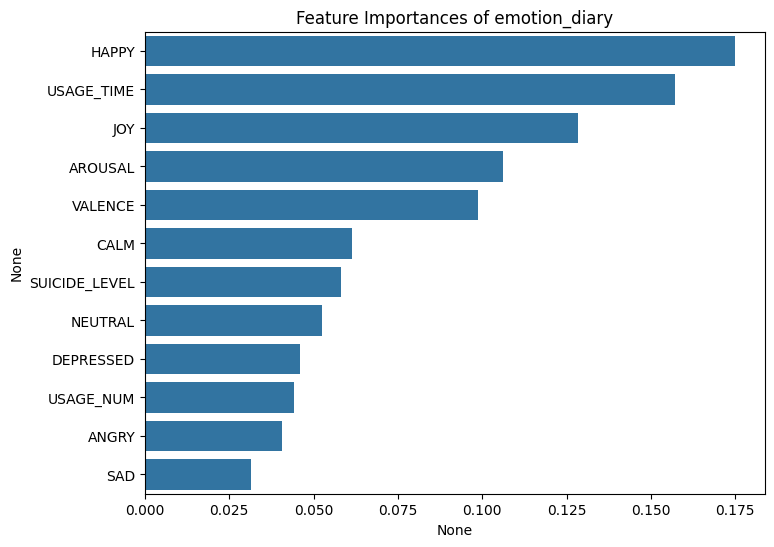


[finding_blue_boat]


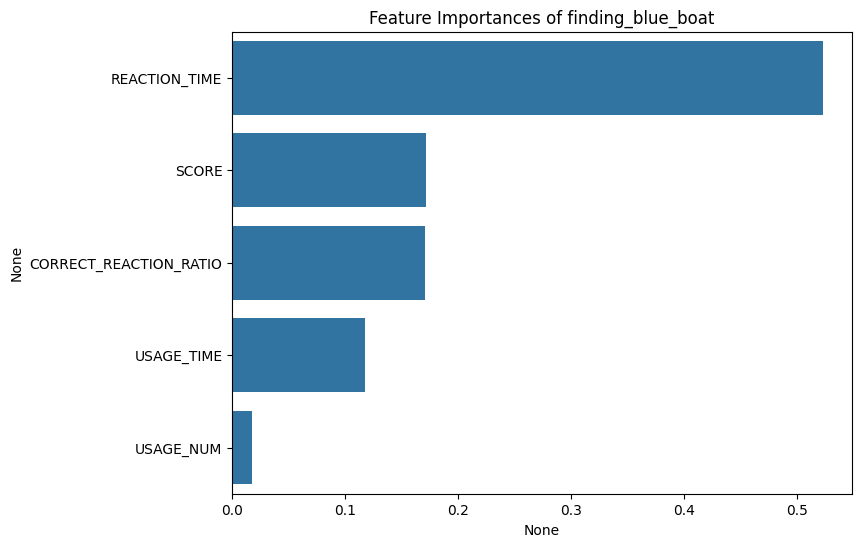


[finding_blue_fishing]


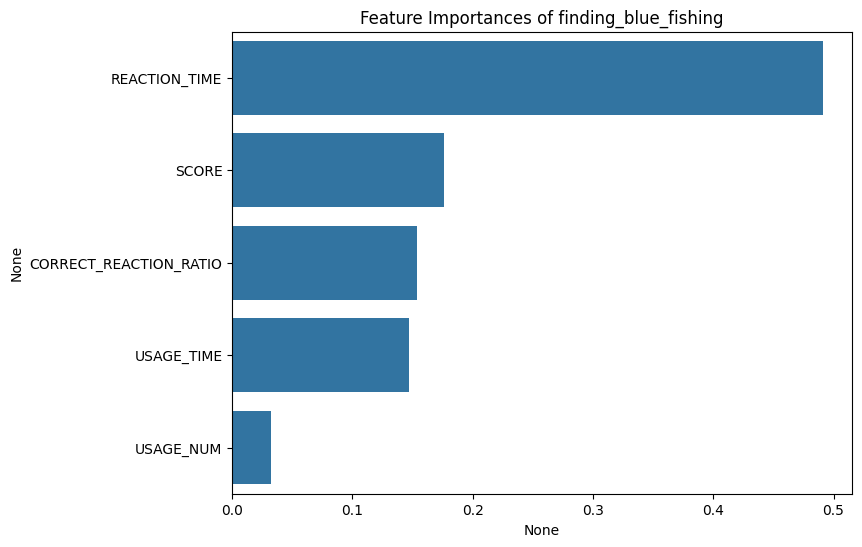


[finding_blue_parachute]


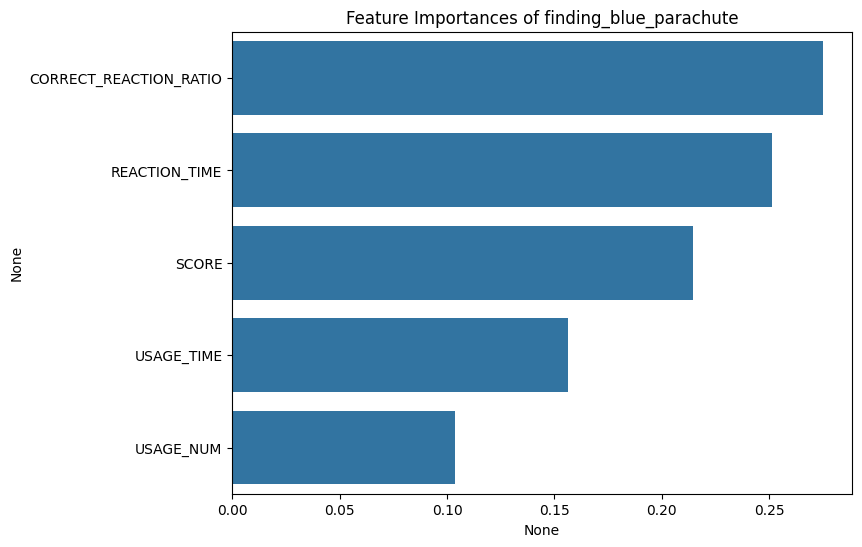


[mandala]


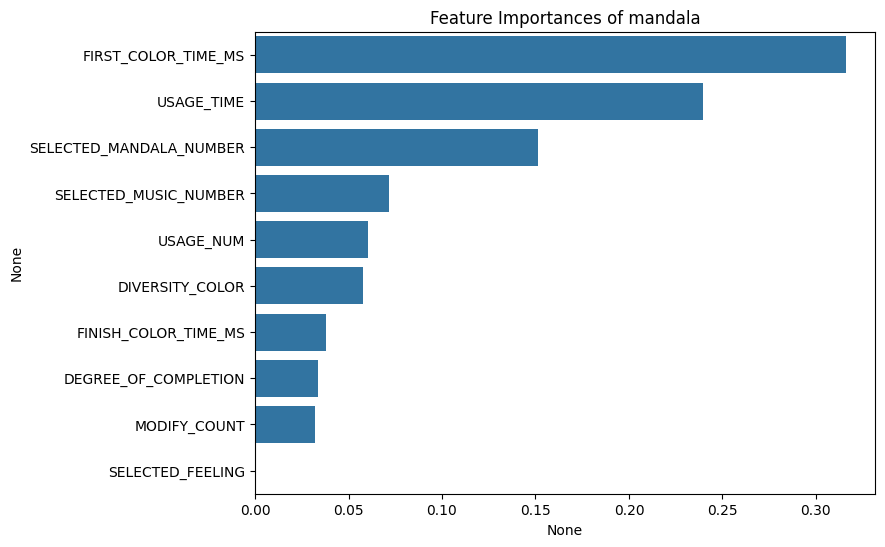


[mindfulness]


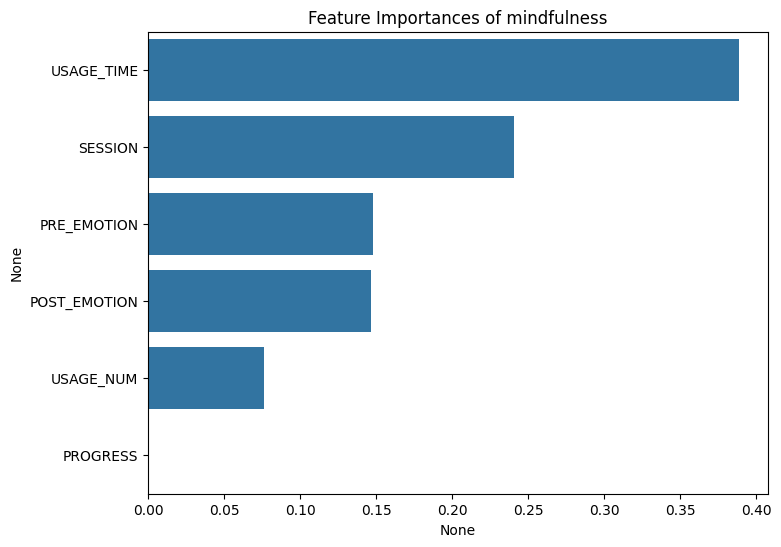


[mindteaching_webtoon]


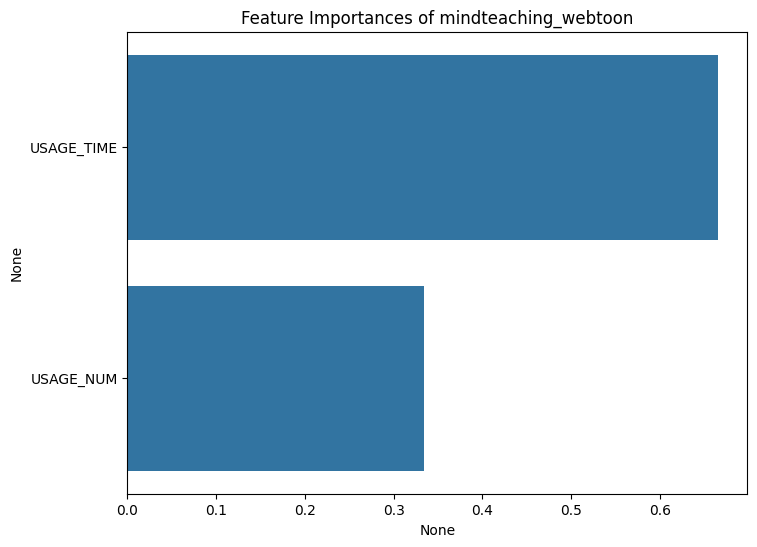


[mysound_current]


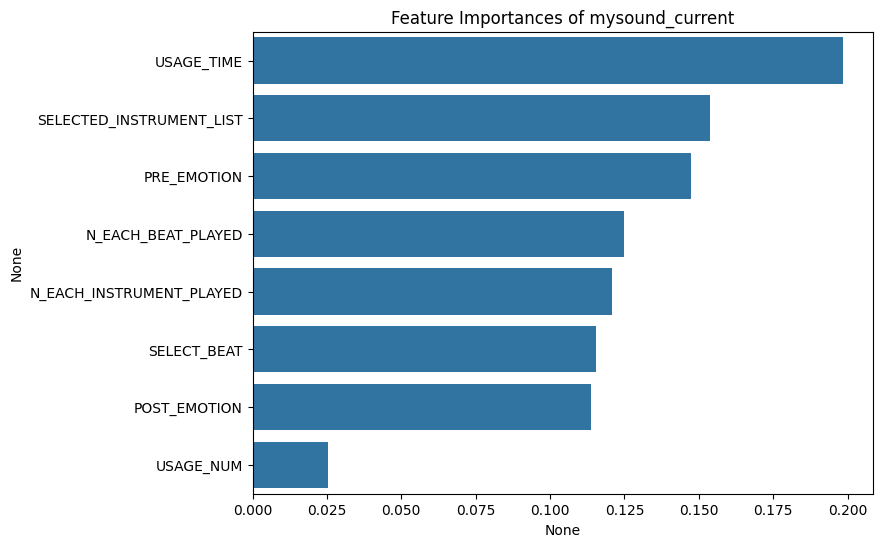


[mysound_pursue]


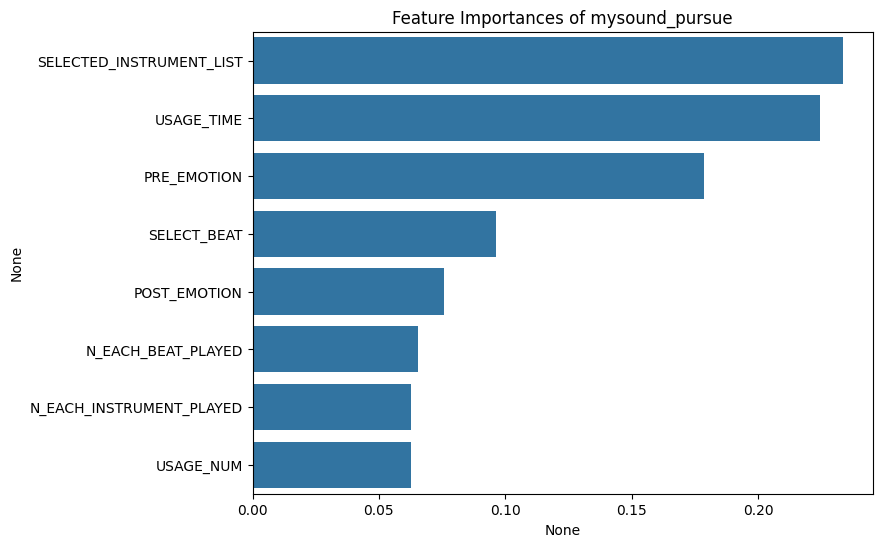


[mysound_listen]


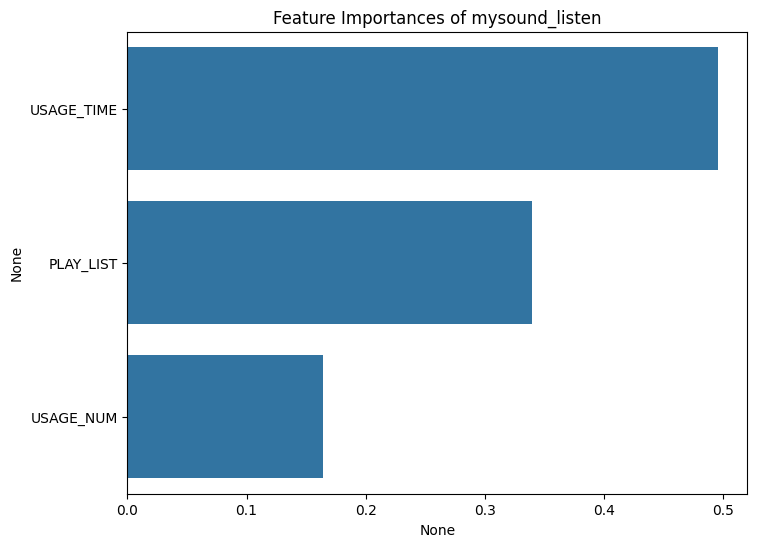

In [193]:
def feature_importance_random_forest(features_list, features_name):
    # 콘텐츠별 랜덤포레스트로 feature별 importances 얻기
    for content_name in features_name.keys():
        # X는 feature 값들, Y는 우울 척도 점수로 추정
        X = pd.DataFrame([features[content_name] for features in features_list if content_name in features], columns=features_name[content_name])
        Y = pd.Series([features["score"] for features in features_list if content_name in features])

        # NaN, inf 값 확인 및 제거
        X = X.replace([np.inf, -np.inf], np.nan).dropna()
        Y = Y[X.index]  # X의 인덱스에 맞춰 Y를 정렬

        # 랜덤 포레스트 모델 생성 및 학습 (분류보다는 회귀 문제이므로 Regressor 사용)
        model = RandomForestRegressor(n_jobs=-1, random_state=42)
        model.fit(X, Y)

        # feature 중요도 추출
        feature_importances = pd.Series(model.feature_importances_, index=X.columns)
        
        # 결과 출력 및 시각화
        print(f"[{content_name}]")
        top_features = feature_importances.sort_values(ascending=False)[:15]
        plt.figure(figsize=(8, 6))
        plt.title(f'Feature Importances of {content_name}')
        sns.barplot(x=top_features, y=top_features.index)
        plt.show()
        print()

feature_importance_random_forest(features_list, features_name)

* SHAP

[emotion_diary]


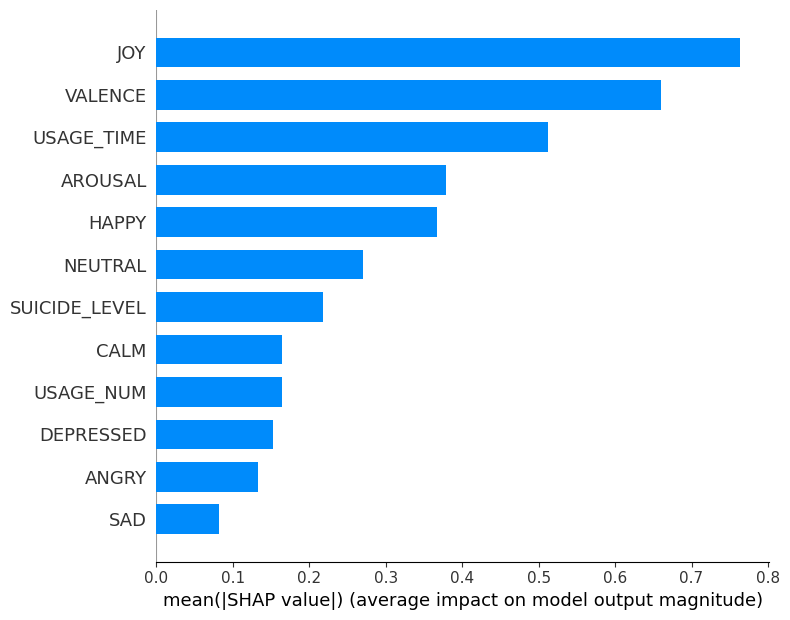


[finding_blue_boat]


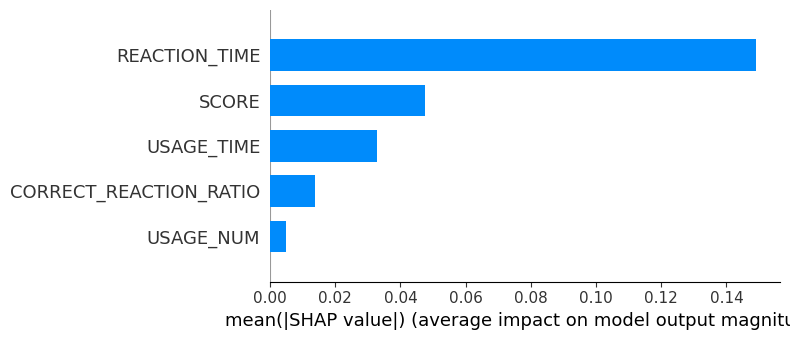


[finding_blue_fishing]


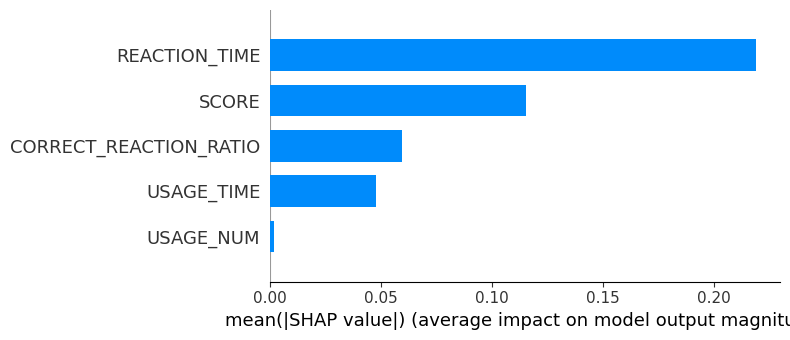


[finding_blue_parachute]


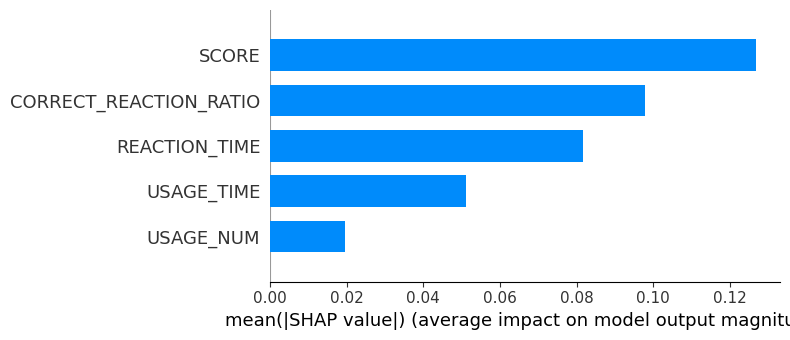


[mandala]


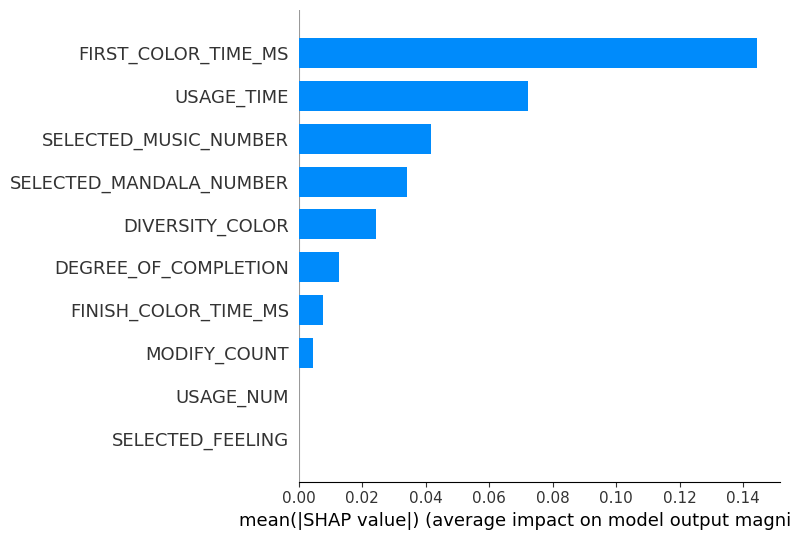


[mindfulness]


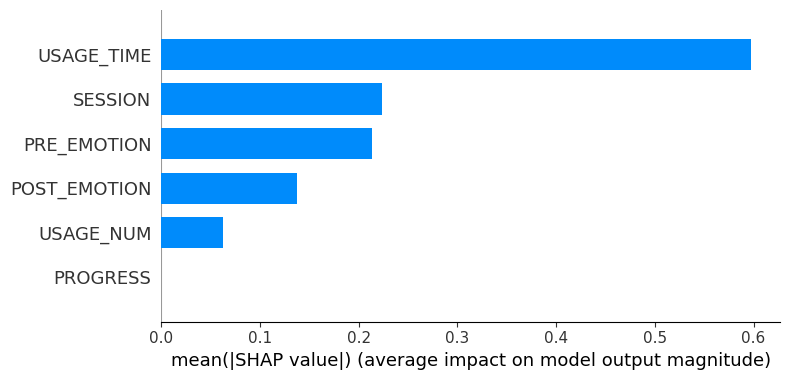


[mindteaching_webtoon]


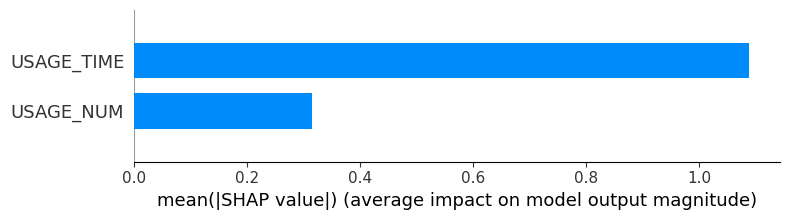


[mysound_current]


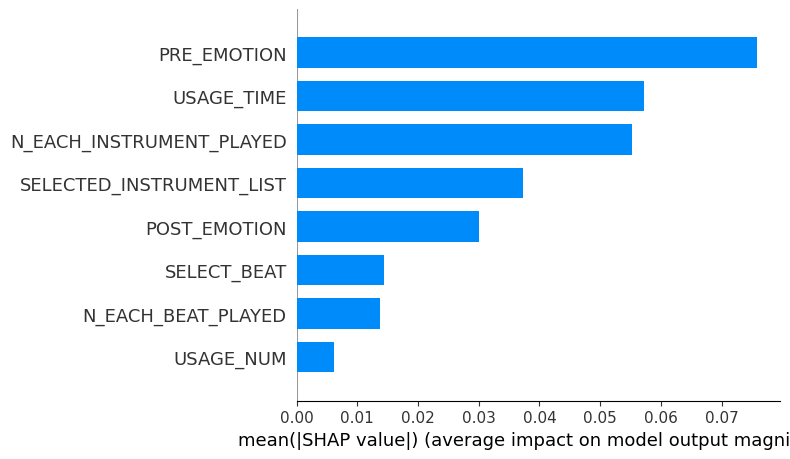


[mysound_pursue]


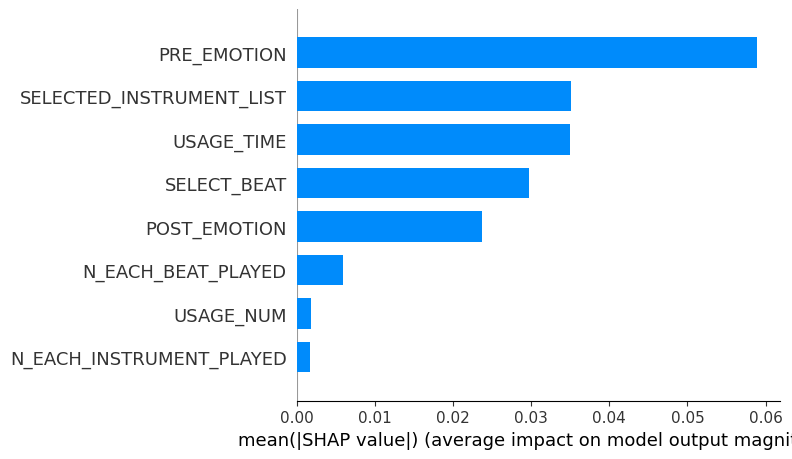


[mysound_listen]


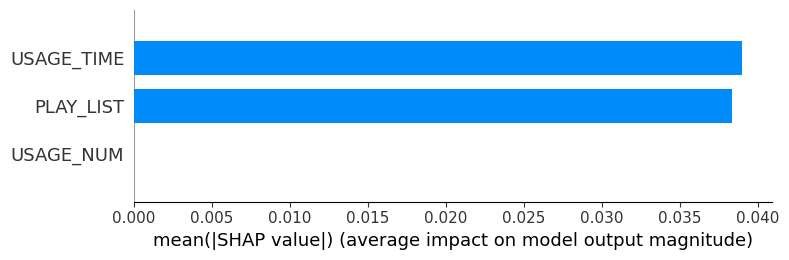

In [192]:
def calculate_shap_importance(features_list, features_name):
    # 콘텐츠별로 SHAP 분석 수행
    for content_name in features_name.keys():
        # X: feature 값들, Y: 우울 척도 점수
        X = pd.DataFrame([features[content_name] for features in features_list if content_name in features], columns=features_name[content_name])
        Y = [features["score"] for features in features_list if content_name in features]

        # 모델 학습
        model = XGBRegressor()
        model.fit(X, Y)

        # SHAP 값 계산 및 시각화
        print(f"[{content_name}]")

        shap.initjs()
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)

        # SHAP summary plot (feature importance)
        shap.summary_plot(shap_values, X, plot_type='bar')
        print()

# SHAP 분석 실행
calculate_shap_importance(features_list, features_name)

09/30
==


In [66]:
def count_monthly_active_users(data):
    monthly_user_count = defaultdict(set)

    for user_id, logs in data.items():
        for log in logs:
            # START_DATE 추출 및 datetime 객체로 변환
            start_date = datetime.strptime(log["START_DATE"], "%Y-%m-%d %H:%M:%S")
            
            # 2023-09 이후의 로그만 고려
            if start_date >= datetime(2023, 9, 1):
                month_str = start_date.strftime("%Y-%m")  # 월별로 분류
                monthly_user_count[month_str].add(user_id)  # 해당 월에 이용한 사용자 추가
    
    # 각 월별로 사용자 수 계산
    monthly_user_counts = {month: len(users) for month, users in monthly_user_count.items()}

    # pandas DataFrame으로 정리 및 정렬
    monthly_user_df = pd.DataFrame(list(monthly_user_counts.items()), columns=['Month', 'User Count'])
    monthly_user_df = monthly_user_df.sort_values(by='Month').reset_index(drop=True)
    
    return monthly_user_df

In [70]:
# 함수 실행
monthly_user_df = count_monthly_active_users(data)
print(monthly_user_df)

      Month  User Count
0   2023-09          23
1   2023-10          32
2   2023-11         110
3   2023-12          79
4   2024-01          42
5   2024-02          21
6   2024-03          37
7   2024-04          32
8   2024-05          15
9   2024-06          15
10  2024-07          12
11  2024-08          12


In [85]:
def count_monthly_content_usage(data):
    # 각 콘텐츠별 월별 이용 횟수를 기록할 딕셔너리 초기화
    content_usage = defaultdict(lambda: defaultdict(int))
    
    # 로그를 순회하며 콘텐츠 이름과 월별 이용 횟수를 기록
    for user_id, logs in data.items():
        for log in logs:
            content_name = log["CONTENTS_NAME"]
            start_date = datetime.strptime(log["START_DATE"], "%Y-%m-%d %H:%M:%S")
            
            # 2023-09 이후의 로그만 고려
            if start_date >= datetime(2023, 9, 1):
                month_str = start_date.strftime("%Y-%m")  # 월별로 분류
                content_usage[content_name][month_str] += 1  # 해당 월에 콘텐츠 사용 횟수 증가
    
    # 결과를 pandas DataFrame으로 변환
    all_months = pd.date_range(start="2023-09", end="2024-08", freq='MS').strftime("%Y-%m").tolist()
    content_names = [
        "cesd10d", "phq9", "emotion_diary", "finding_blue_boat", "finding_blue_fishing",
        "finding_blue_parachute", "mandala", "mindteaching_webtoon", "mindfulness",
        "mysound_pursue", "mysound_current", "mysound_listen"
    ]
    
    # DataFrame 생성 및 초기화
    usage_df = pd.DataFrame(index=content_names, columns=all_months).fillna(0)
    
    # DataFrame에 각 콘텐츠의 월별 이용 횟수 기록
    for content_name, monthly_data in content_usage.items():
        for month, count in monthly_data.items():
            if content_name in usage_df.index:
                usage_df.loc[content_name, month] = count
    
    return usage_df

In [86]:
monthly_content_usage_df = count_monthly_content_usage(data)
print(monthly_content_usage_df)

                        2023-09  2023-10  2023-11  2023-12  2024-01  2024-02  \
cesd10d                      30       37      275      179       48       20   
phq9                         14       18       69       82       26       11   
emotion_diary                60       93     1183      640      169       87   
finding_blue_boat             3        5       63       10        0        0   
finding_blue_fishing          5        7       88       22        3        1   
finding_blue_parachute        6        7       77       29        7        0   
mandala                       1        5       29       16        4        0   
mindteaching_webtoon         62       80      786      557      131       11   
mindfulness                  27       48      330      104       13        0   
mysound_pursue                0        6       41       23        1        0   
mysound_current               1        5       52       26        1        0   
mysound_listen                0        0

C:\Users\ppjw0\AppData\Local\Temp\ipykernel_22208\432384310.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  usage_df = pd.DataFrame(index=content_names, columns=all_months).fillna(0)


In [87]:
def calculate_average_usage_time_per_user(data):
    user_usage_time = defaultdict(lambda: defaultdict(float))  # stores total usage time per user per month
    monthly_usage_time = defaultdict(lambda: [0, 0])  # stores [total time, user count] per month

    for user_id, logs in data.items():
        for log in logs:
            start_date = datetime.strptime(log["START_DATE"], "%Y-%m-%d %H:%M:%S")
            end_date = datetime.strptime(log["END_DATE"], "%Y-%m-%d %H:%M:%S")
            session_time = (end_date - start_date).total_seconds()  # session time in seconds
            
            # only consider data from 2023-09 and later
            if start_date >= datetime(2023, 9, 1):
                month_str = start_date.strftime("%Y-%m")
                user_usage_time[user_id][month_str] += session_time

    # Calculate monthly average usage time across all users
    for user_id, month_data in user_usage_time.items():
        for month, total_time in month_data.items():
            monthly_usage_time[month][0] += total_time
            monthly_usage_time[month][1] += 1  # Count each user once per month

    # Calculate monthly average usage time
    monthly_average_time = {
        month: total_time / user_count if user_count > 0 else 0
        for month, (total_time, user_count) in monthly_usage_time.items()
    }
    
    # Calculate overall average usage time
    overall_total_time = sum(time[0] for time in monthly_usage_time.values())
    overall_user_count = sum(time[1] for time in monthly_usage_time.values())
    overall_average_time = overall_total_time / overall_user_count if overall_user_count > 0 else 0
    
    # Create DataFrame for monthly average usage time
    all_months = pd.date_range(start="2023-09", end="2024-08", freq='MS').strftime("%Y-%m").tolist()
    monthly_average_time_df = pd.DataFrame([monthly_average_time.get(month, 0) for month in all_months],
                                           index=all_months, columns=["Average Usage Time (seconds)"])
    
    return overall_average_time, monthly_average_time_df

In [88]:
# 함수 실행
overall_average_time, monthly_average_time_df = calculate_average_usage_time_per_user(data)

# 전체 평균 이용 시간 출력
print(f"Overall Average Usage Time: {overall_average_time:.2f} seconds")

# 월별 평균 이용 시간 출력
print(monthly_average_time_df)

Overall Average Usage Time: 2659.72 seconds
         Average Usage Time (seconds)
2023-09                   2150.434783
2023-10                   2608.187500
2023-11                   4866.745455
2023-12                   3517.075949
2024-01                   1542.238095
2024-02                   1043.095238
2024-03                    447.945946
2024-04                    300.312500
2024-05                    373.133333
2024-06                    324.533333
2024-07                   4097.333333
2024-08                   2089.166667
